# Database Implementation

## Database Creation

In [1]:
import sqlite3
import os
from google.colab import drive, userdata

drive.mount('/content/drive')

db_path = '/content/drive/MyDrive/DecodingDemocracy/db.sqlite'

!pip install --no-cache-dir -r '/content/drive/My Drive/DecodingDemocracy/requirements.txt'

conn = sqlite3.connect('db.sqlite')
cursor = conn.cursor()

def create_db():
    cursor.execute('DROP TABLE IF EXISTS Consultation')
    cursor.execute('DROP TABLE IF EXISTS Question')
    cursor.execute('DROP TABLE IF EXISTS Responder')
    cursor.execute('DROP TABLE IF EXISTS Response')
    cursor.execute('DROP TABLE IF EXISTS Clusters')
    cursor.execute('DROP TABLE IF EXISTS Topics')

    # Create Consultation table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS Consultation (
        id INTEGER PRIMARY KEY,
        consultation_name TEXT,
        date DATE,
        published_responses_url TEXT,
        government_analysis_url TEXT,
        prerequisite_material_url TEXT
    )
    ''')
    # Create Question table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS Question (
        id TEXT PRIMARY KEY,
        consultation_id INTEGER,
        question TEXT,
        multiplechoice BOOLEAN,
        wordcloud BLOB,
        response_embeddings BLOB,
        FOREIGN KEY (consultation_id) REFERENCES Consultation(id)
    )
    ''')
    # Create Responder table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS Responder (
        id INTEGER PRIMARY KEY,
        submitted_date DATE,
        published_response_url TEXT,
        type TEXT,
        consultation_id INTEGER,
        FOREIGN KEY (consultation_id) REFERENCES Consultation(id)
    )
    ''')
    # Create Response table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS Response (
        id INTEGER PRIMARY KEY,
        question_id TEXT,
        responder_id INTEGER,
        response TEXT,
        consultation_id INTEGER,
        sentiment_value FLOAT,
        topic_id TEXT,
        FOREIGN KEY (question_id) REFERENCES Question(id),
        FOREIGN KEY (responder_id) REFERENCES Responder(id),
        FOREIGN KEY (consultation_id) REFERENCES Consultation(id),
        FOREIGN KEY (topic_id) REFERENCES Topics(topic_id),
    )
    ''')
    # Create Topics table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS Topics (
        topic_id TEXT PRIMARY KEY,
        topic_label TEXT
    )
    ''')
    # Create TopicWords table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS TopicWords (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        topic_id TEXT,
        word TEXT,
        word_value TEXT,
        FOREIGN KEY (topic_id) REFERENCES Topics(topic_id)
    )
    ''')

    conn.commit()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.7/95.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 38.5 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement Brlapi==0.8.2 (from versions: none)
ERROR: No matching distribution found for Brlapi==0.8.2


## Database Population

### Extract excel data into csv files

In [ ]:
# script to convert excel files to csv files that can be imported into sqlite
import pandas as pd

# label for 'responder_type' column
RESPONDER_TYPE_COLUMN = 'Are you responding as an individual or an organisation? - Are you responding as an individual or an organisation?'

# define fields for each consultation excel file for processing
CONSULTATIONS = [
    {
        "consultation_name": "Consultation on a Draft Referendum Bill",
        "date": "2016-10-20",
        "published_responses_url": "https://consult.gov.scot/elections-and-constitutional-development-division/draft-referendum-bill/consultation/view_respondent?uuId=",
        "government_analysis_url": "https://www.gov.scot/publications/consultation-draft-referendum-bill-analysis-responses/",
        "prerequisite_material_url": "https://webarchive.nrscotland.gov.uk/3000/https://www.gov.scot/publications/consultation-draft-referendum-bill/",
        "excel_file": "/content/drive/My Drive/DecodingDemocracy/excel/2016responses.xlsx",
        "id": 1,
        "start_column": 6, # first question column
        "end_column": 11 # last question column
    },
    {
        "consultation_name": "Consultation on a Electoral Reform",
        "date": "2017-12-19",
        "published_responses_url": "https://consult.gov.scot/elections/electoral-reform/consultation/view_respondent?uuId=",
        "government_analysis_url": "https://www.gov.scot/publications/electoral-reform-consultation-analysis/",
        "prerequisite_material_url": "https://www.gov.scot/publications/consultation-electoral-reform/",
        "excel_file": "/content/drive/My Drive/DecodingDemocracy/excel/2017responses.xlsx",
        "id": 2,
        "start_column": 0, # first question column
        "end_column": 45 # last question column
    },
    {
        "consultation_name": "Consultation on a Electoral Reform",
        "date": "2022-12-14",
        "published_responses_url": "https://consult.gov.scot/constitution-and-cabinet/electoral-reform/consultation/view_respondent?uuId=",
        "government_analysis_url": "https://www.gov.scot/publications/electoral-reform-consultation-analysis-2/",
        "prerequisite_material_url": "https://www.gov.scot/publications/electoral-reform-consultation/",
        "excel_file": "/content/drive/My Drive/DecodingDemocracy/excel/2023responses.xlsx",
        "id": 3,
        "start_column": 0, # first question column
        "end_column": 53 # last question column
    }
]

# store consultations in a csv file
def get_consultations():
    # DB columns are consultation_id, name, date, published_responses_url, government_analysis_url, prerequisite_material_url
    consultations = []
    for c in CONSULTATIONS:
        consultations.append({
            'id': c['id'],
            'consultation_name': c['consultation_name'],
            'date': c['date'],
            'published_responses_url': c['published_responses_url'],
            'government_analysis_url': c['government_analysis_url'],
            'prerequisite_material_url': c['prerequisite_material_url']
        })
    file = pd.DataFrame(consultations)
    # write the dataframe to a csv file
    file.to_csv('/content/drive/My Drive/DecodingDemocracy/csv/consultations.csv', index=False)

# store responders in csv files
def get_responders(filename,consultation_id):
    # read Unique ID, Submitted Date, Responder Type and Published Response URL columns
    file = pd.read_excel(filename, sheet_name=0)
    # create a new dataframe with the columns
    file = pd.DataFrame({
        'id': file['Unique ID'],
        'submitted_date': file['Submitted Date'],
        'type': file[RESPONDER_TYPE_COLUMN],
        'published_response_url': file['Published Response URL'],
        'consultation_id': consultation_id
    })
    # write the dataframe to a csv file
    file.to_csv('/content/drive/My Drive/DecodingDemocracy/csv/responders' + str(consultation_id) + '.csv', index=False)

# store questions in csv files
def get_questions(start_column, end_column, filename, consultation_id):
    file = pd.read_excel(filename, sheet_name=0)
    # read each question from the defined start and end columns
    questions = file.columns[start_column:end_column]
    # create a new dataframe with the questions
    file = pd.DataFrame({
        'id': [str(consultation_id) + '-' + str(i) for i in range(1, len(questions)+1)],
        'consultation_id': consultation_id,
        'question': questions,
        'multiplechoice': 0 # by default not a MCQ - will be updated later
    })
    # write the dataframe to a csv file
    file.to_csv('/content/drive/My Drive/DecodingDemocracy/csv/questions' + str(consultation_id) + '.csv', index=False)

# store responses in csv files
def get_responses(start_column,end_column,filename,consultation_id):
    df = pd.read_excel(filename, sheet_name=0)

    # define fields for the database responses table
    responses_df = pd.DataFrame(columns=['question_id', 'responder_id', 'response', 'consultation_id'])

    current_id = 0 # keep count of response id
    for i in range(start_column, end_column): # only look at columns with responses in the file
        # index i represents the current question
        responses = df.iloc[:, i] # get column i responses from the excel file
        # text processing - remove new line characters, paragraph and line separators
        responses = responses.str.replace('\n', ' ')
        responses = responses.str.replace('\r', ' ')
        responses = responses.str.replace('\u2028', ' ')
        num_responses = len(responses)
        # add all the responses for the question to the dataframe
        responses_df = pd.concat(
            [
                responses_df,
                pd.DataFrame({
                    'question_id': [str(consultation_id) + '-' + str(i-start_column+1)] * num_responses,
                    'responder_id': df['Unique ID'],
                    'response': responses,
                    'consultation_id': [consultation_id for _ in range(num_responses)],
                })
            ], ignore_index=True)
        current_id += num_responses + 1 # increment response id

    # write the dataframe to a csv file
    responses_df.to_csv('/content/drive/My Drive/DecodingDemocracy/csv/responses' + str(consultation_id) + '.csv', index=False)

# create all csv files with the defined functions
def create_csv_files():
  get_consultations()
  for c in CONSULTATIONS:
      get_responders(c['excel_file'],c['id'])
      get_questions(c['start_column'],c['end_column'],c['excel_file'],c['id'])
      get_responses(c['start_column'],c['end_column'],c['excel_file'],c['id'])

  # combine all the responders, questions and responses csv files into one file for each
  responders = pd.concat([pd.read_csv('/content/drive/My Drive/DecodingDemocracy/csv/responders' + str(i+1) + '.csv') for i in range(len(CONSULTATIONS))], ignore_index=True)
  questions = pd.concat([pd.read_csv('/content/drive/My Drive/DecodingDemocracy/csv/questions' + str(i+1) + '.csv') for i in range(len(CONSULTATIONS))], ignore_index=True)
  responses = pd.concat([pd.read_csv('/content/drive/My Drive/DecodingDemocracy/csv/responses' + str(i+1) + '.csv') for i in range(len(CONSULTATIONS))], ignore_index=True)
  # write the dataframes to csv files
  responders.to_csv('/content/drive/My Drive/DecodingDemocracy/csv/responders.csv', index=False)
  questions.to_csv('/content/drive/My Drive/DecodingDemocracy/csv/questions.csv', index=False)
  responses.to_csv('/content/drive/My Drive/DecodingDemocracy/csv/responses.csv', index=False)

### Load data into Database



In [2]:
# Load csv files into database
def load_data_to_db(conn, cursor):
  # Load consultations.csv into Consultation table
  consultation_df = pd.read_csv('/content/drive/My Drive/DecodingDemocracy/csv/consultations.csv')
  consultation_df.to_sql('Consultation', conn, if_exists='append', index=False)

  # Load questions.csv into Question table
  question_df = pd.read_csv('/content/drive/My Drive/DecodingDemocracy/csv/questions.csv')
  question_df.to_sql('Question', conn, if_exists='append', index=False)

  # Load responders.csv into Responder table
  responder_df = pd.read_csv('/content/drive/My Drive/DecodingDemocracy/csv/responders.csv')
  responder_df.to_sql('Responder', conn, if_exists='append', index=False)

  # Load responses.csv into Response table
  response_df = pd.read_csv('/content/drive/My Drive/DecodingDemocracy/csv/responses.csv')
  response_df.to_sql('Response', conn, if_exists='append', index=False)

  # Multiple choice question ids - no indication in excel files so must be hard coded
  multiplechoice2 = ['2-1', '2-4', '2-6', '2-7', '2-9', '2-11', '2-12', '2-13', '2-18', '2-19', '2-20', '2-22', '2-23', '2-24', '2-26', '2-28', '2-29', '2-30', '2-32', '2-34', '2-39', '2-41']
  multiplechoice3 = ['3-1', '3-2', '3-4', '3-6', '3-7', '3-9', '3-10', '3-13', '3-15', '3-17', '3-19', '3-20', '3-23', '3-25', '3-27', '3-28', '3-29', '3-30', '3-32', '3-33', '3-36', '3-37', '3-39', '3-41', '3-42', '3-43', '3-45', '3-47', '3-50', '3-53']

  # update multiplechoice field in Question table for each MCQ
  sql = 'UPDATE Question SET multiplechoice = 1 WHERE id=?'
  for i in multiplechoice2:
    cursor.execute(sql, (i,))
  for i in multiplechoice3:
    cursor.execute(sql, (i,))
  conn.commit()


if os.path.exists(db_path): # already exists - no need to create db
    print("Database exists. Copying to Colab environment.")
    !cp {db_path} .
else: # create the database from scratch, by converting excel files to csv then loading them into sqlite
  create_db()
  create_csv_files()
  load_data_to_db(conn, cursor)

# Save database in google drive
!cp db.sqlite /content/drive/MyDrive/DecodingDemocracy/

Database exists. Copying to Colab environment.


### Check the data has been loaded correctly

In [3]:
cursor.execute('SELECT * FROM Consultation')
cursor.fetchall()

[(1,
  'Consultation on a Draft Referendum Bill',
  '2016-10-20',
  'https://consult.gov.scot/elections-and-constitutional-development-division/draft-referendum-bill/consultation/view_respondent?uuId=',
  'https://www.gov.scot/publications/consultation-draft-referendum-bill-analysis-responses/',
  'https://webarchive.nrscotland.gov.uk/3000/https://www.gov.scot/publications/consultation-draft-referendum-bill/'),
 (2,
  'Consultation on a Electoral Reform',
  '2017-12-19',
  'https://consult.gov.scot/elections/electoral-reform/consultation/view_respondent?uuId=',
  'https://www.gov.scot/publications/electoral-reform-consultation-analysis/',
  'https://www.gov.scot/publications/consultation-electoral-reform/'),
 (3,
  'Consultation on a Electoral Reform',
  '2022-12-14',
  'https://consult.gov.scot/constitution-and-cabinet/electoral-reform/consultation/view_respondent?uuId=',
  'https://www.gov.scot/publications/electoral-reform-consultation-analysis-2/',
  'https://www.gov.scot/publicati

# Library Installations and Imports

In [3]:
# Installations
!pip install sentence-transformers
!pip install vaderSentiment
!pip install textblob
!pip install demoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.1 MB/s eta 0:00:00


In [4]:
# Data Analysis and Manipulation
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import random
import csv
import json
import os
import pickle
import string
import regex as re
import time
import concurrent.futures

# NLP and Text Processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import demoji

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim import corpora, models
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
from sentence_transformers import SentenceTransformer

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS

# Machine Learning and Feature Extraction
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
import torch
from scipy.special import softmax
import urllib.request
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import TfidfModel, LdaMulticore

# Progress Monitoring
from tqdm import tqdm

# Exploratory Data Analysis

## Total Responses

In [10]:
def total_responses(consultation_id):
  cursor.execute('SELECT COUNT(id) FROM Response WHERE consultation_id = ?', (consultation_id,))
  total = cursor.fetchone()[0]
  return total

tot1 = total_responses(1)
tot2 = total_responses(2)
tot3 = total_responses(3)
total = tot1 + tot2 + tot3
print("Total Repsonses over all consultations: " + str(total))

Total Repsonses over all consultations: 96086


## Responses over time

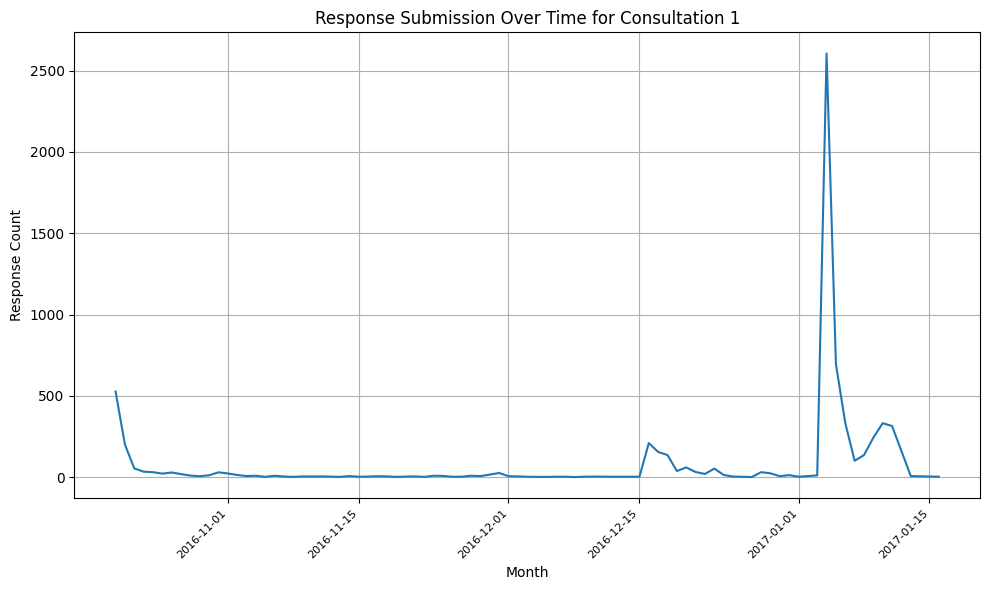

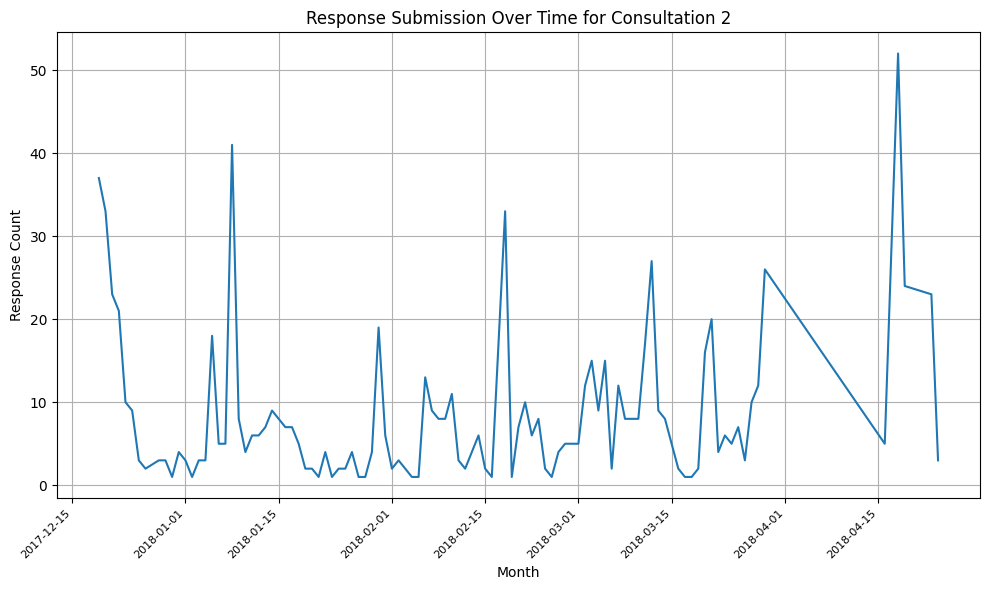

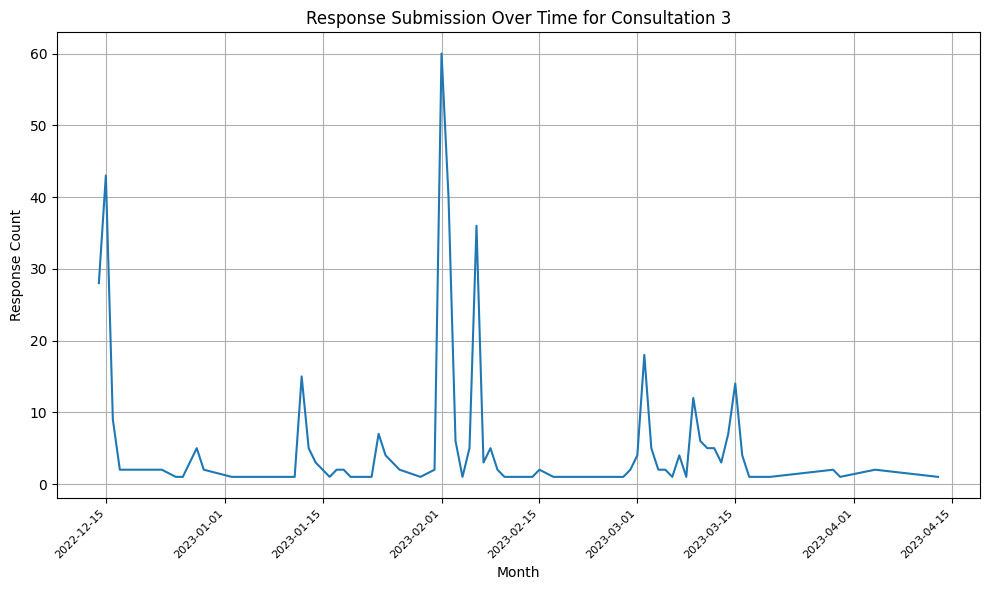

In [27]:
# Response Submission Over Time for one consultation
def response_submission_over_time(consultation_id):
    cursor.execute("SELECT strftime('%Y-%m-%d', submitted_date) AS Submission_Month, COUNT(*) FROM Responder WHERE consultation_id = ? GROUP BY strftime('%Y-%m-%d', submitted_date)", (consultation_id,))
    submission_dates = cursor.fetchall()
    submission_dates_df = pd.DataFrame(submission_dates, columns=['Submission Month', 'Response Count'])

    # Convert the 'Submission Month' column to datetime objects
    submission_dates_df['Submission Month'] = pd.to_datetime(submission_dates_df['Submission Month'], format='%Y-%m')

    plt.figure(figsize=(10, 6))
    plt.plot(submission_dates_df['Submission Month'], submission_dates_df['Response Count'])
    plt.title(f'Response Submission Over Time for Consultation {consultation_id}')
    plt.xlabel('Month')
    plt.ylabel('Response Count')
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

response_submission_over_time(1)
response_submission_over_time(2)
response_submission_over_time(3)


## Responser Types - Organisations vs Individuals

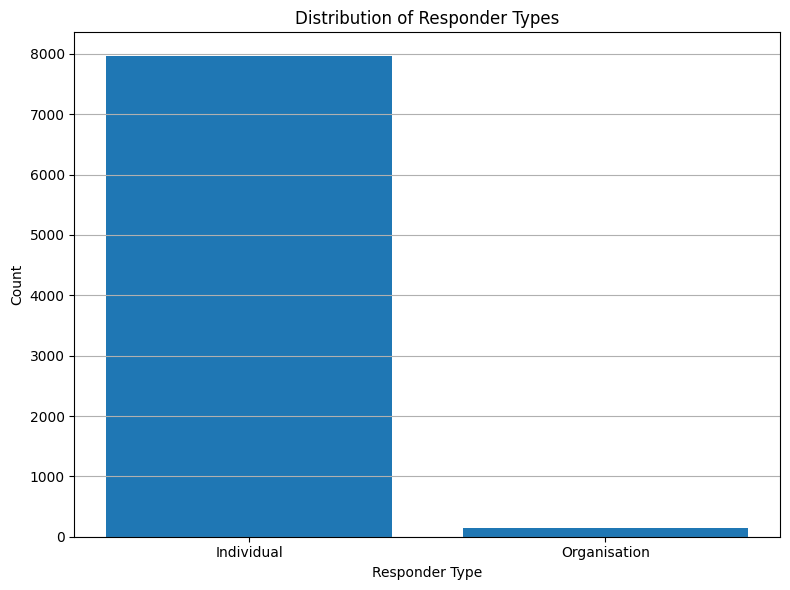

In [29]:
# Types of responders
def responder_types_distribution():
    cursor.execute("SELECT type, COUNT(*) FROM Responder GROUP BY type")
    responder_types = cursor.fetchall()
    responder_types_df = pd.DataFrame(responder_types, columns=['Responder Type', 'Count'])

    plt.figure(figsize=(8, 6))
    plt.bar(responder_types_df['Responder Type'], responder_types_df['Count'])
    plt.title('Distribution of Responder Types')
    plt.xlabel('Responder Type')
    plt.ylabel('Count')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

responder_types_distribution()

## Multiple Choice Responses

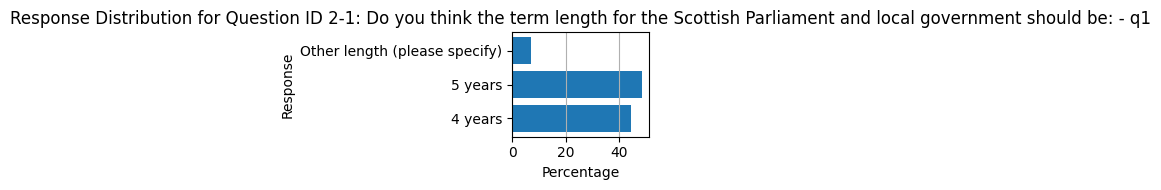

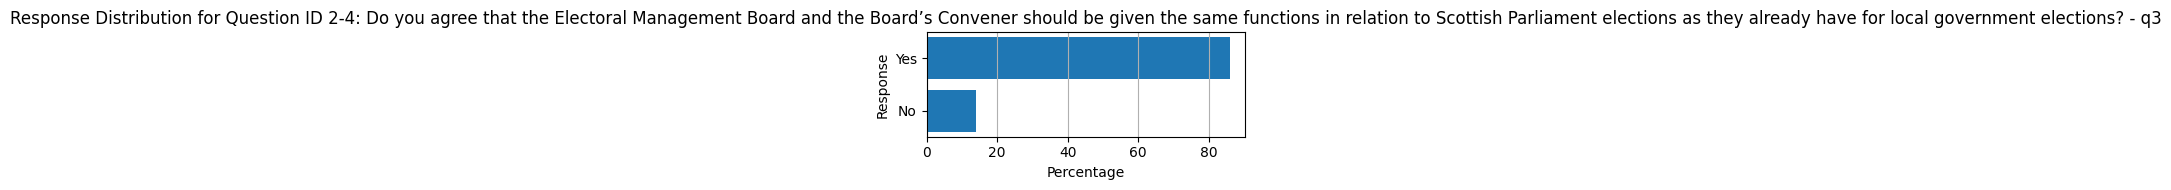

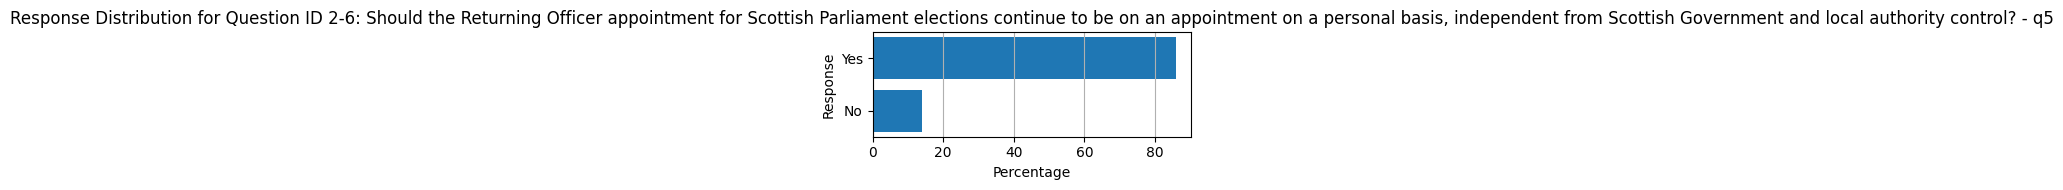

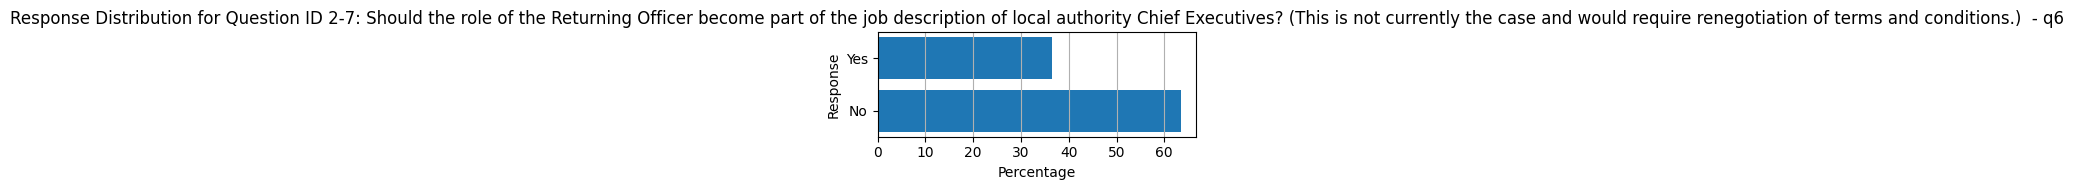

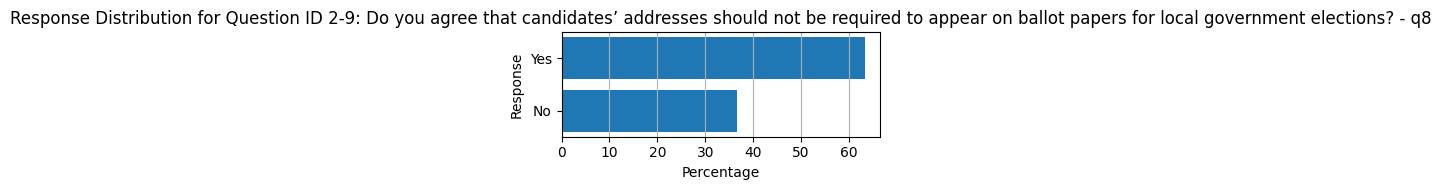

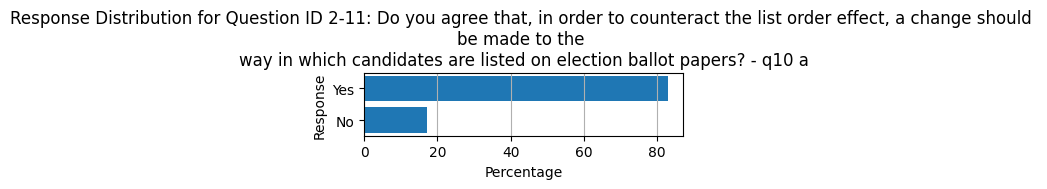

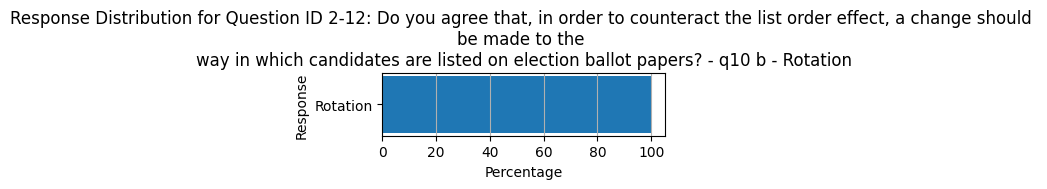

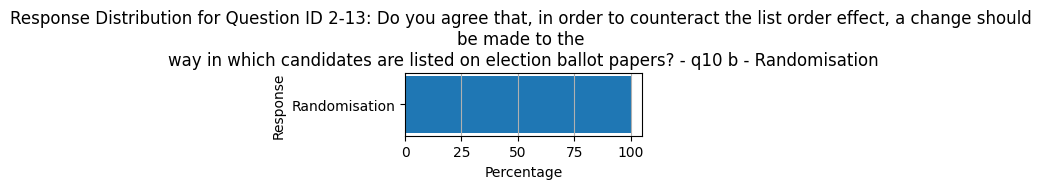

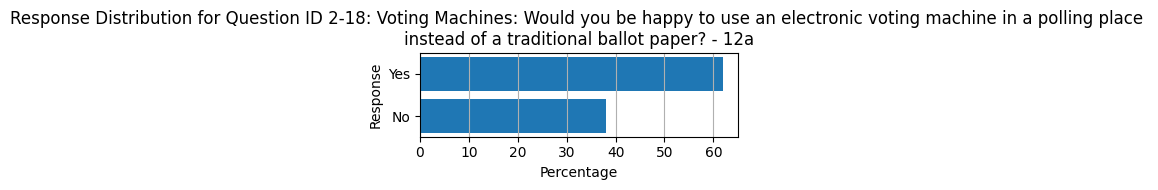

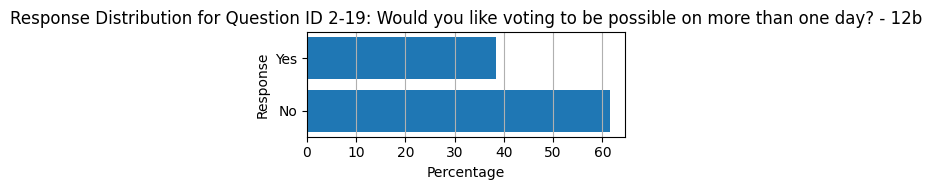

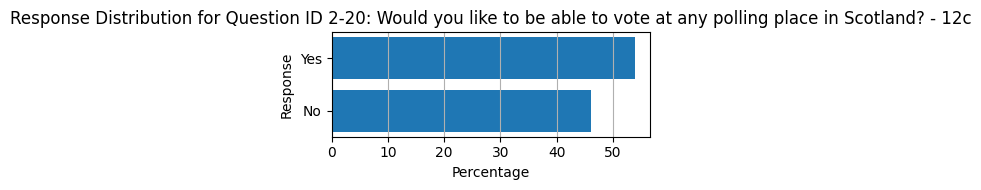

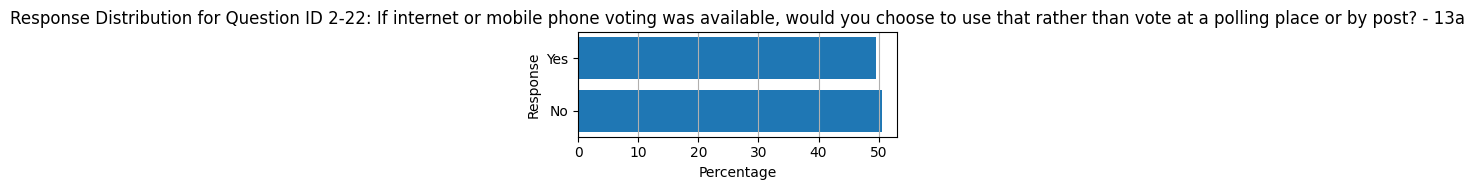

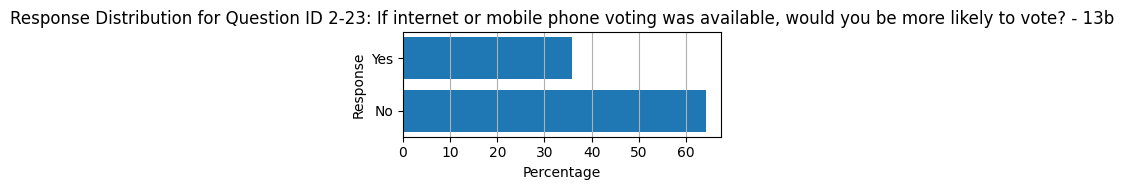

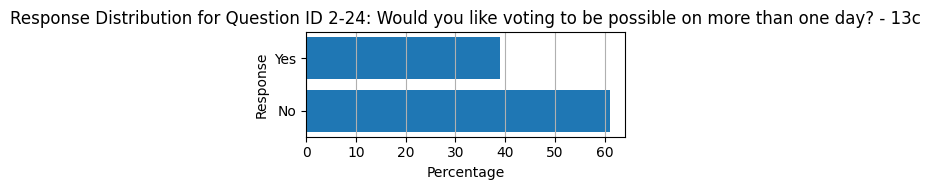

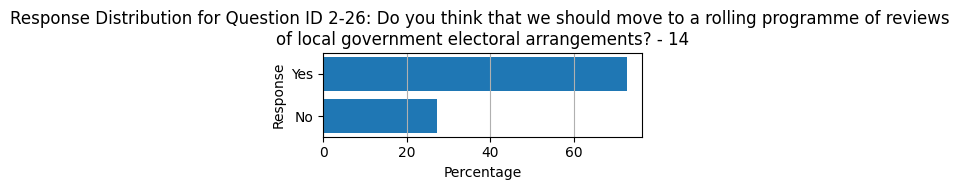

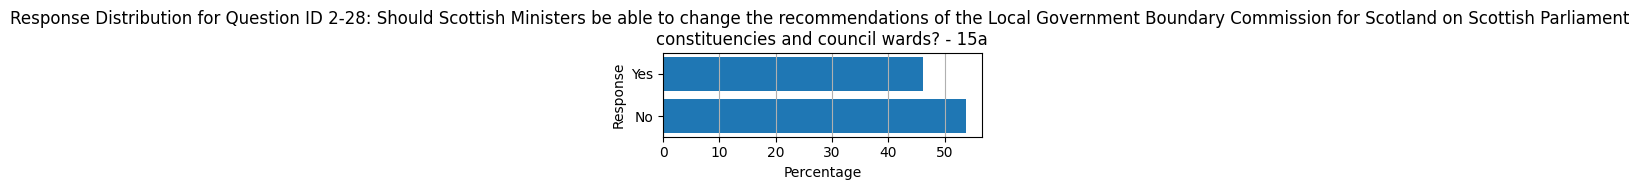

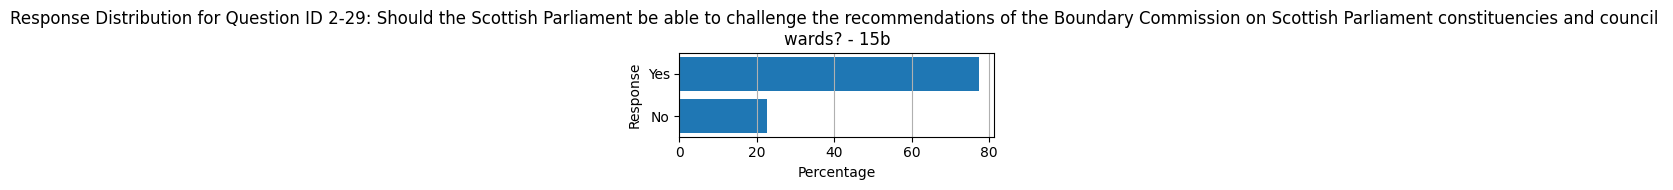

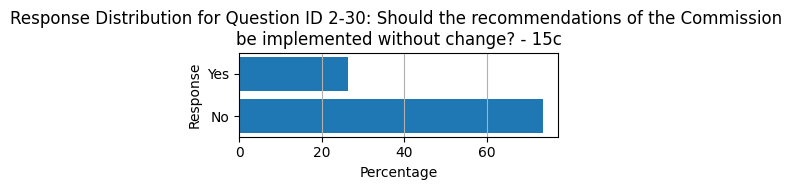

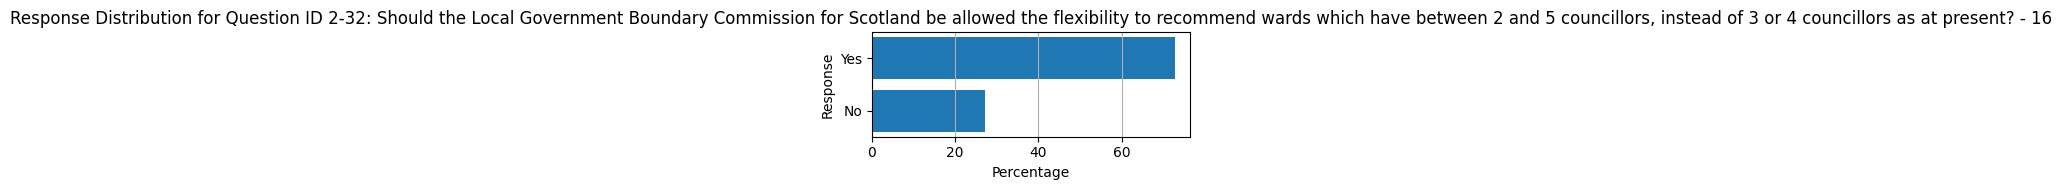

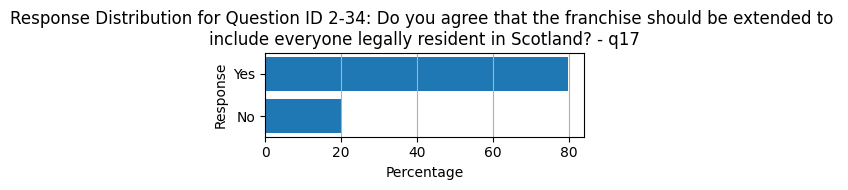

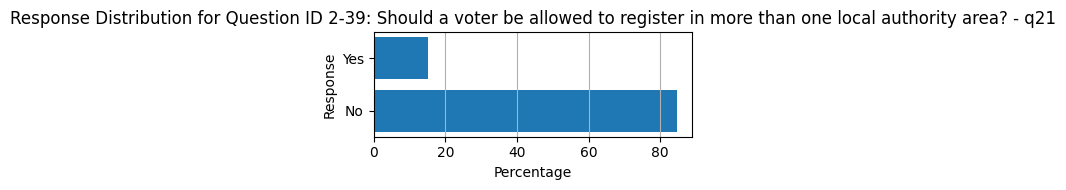

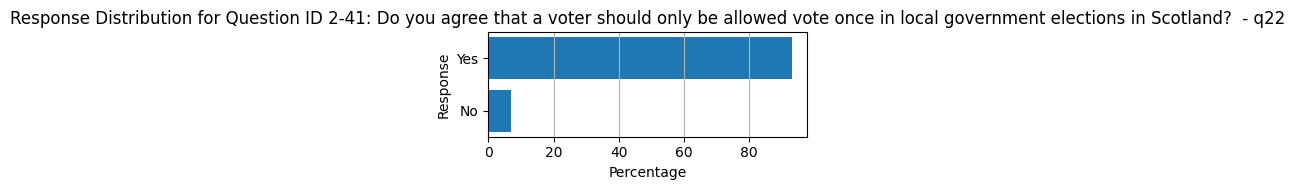

<ipython-input-34-f2dc4fd7c388>:39: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


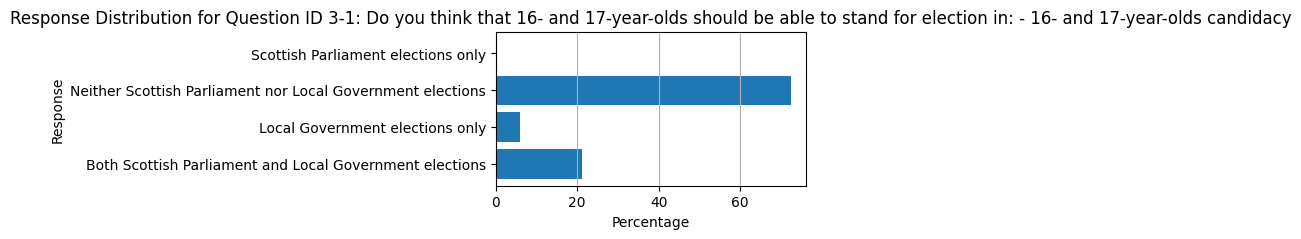

<ipython-input-34-f2dc4fd7c388>:39: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


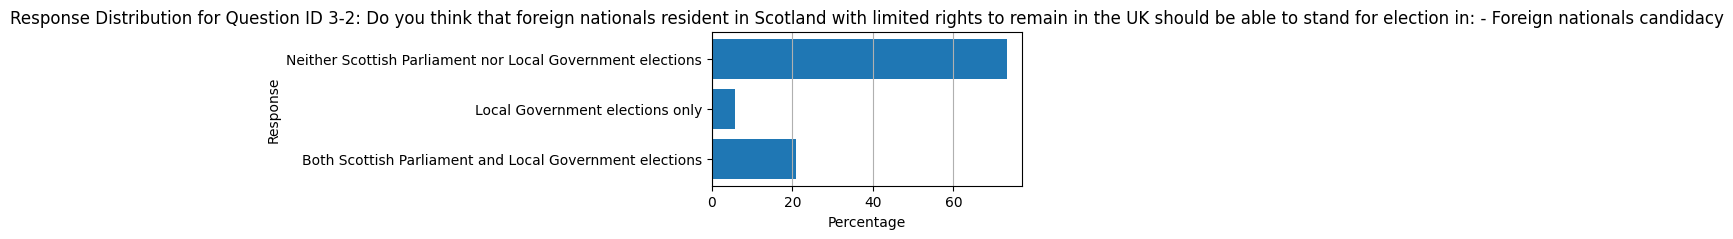

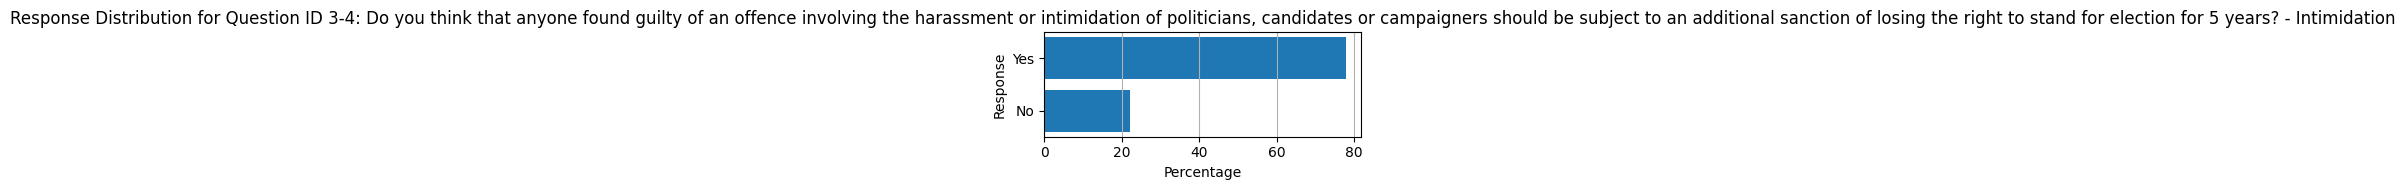

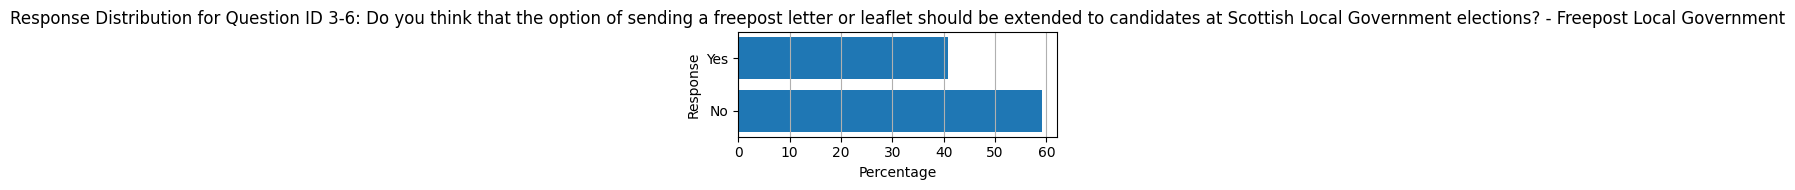

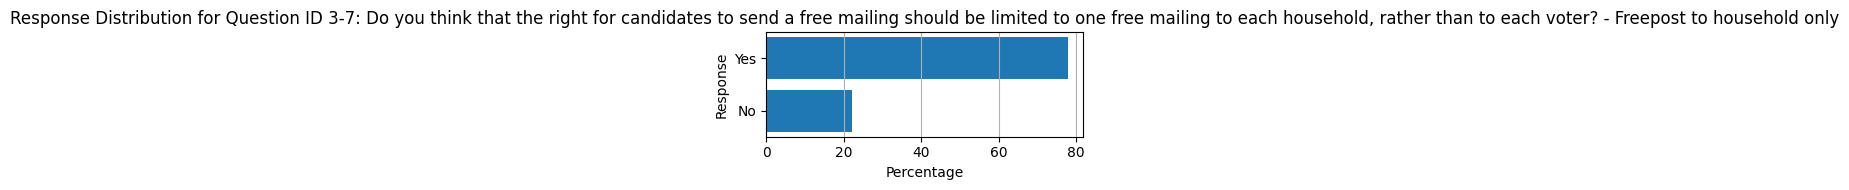

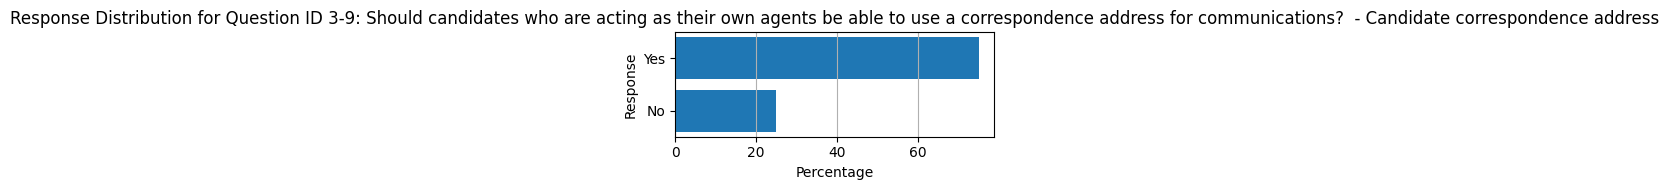

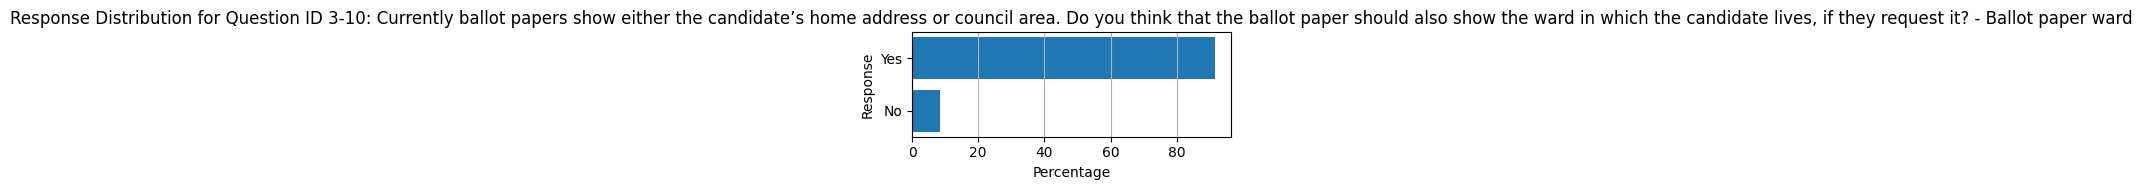

<ipython-input-34-f2dc4fd7c388>:39: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


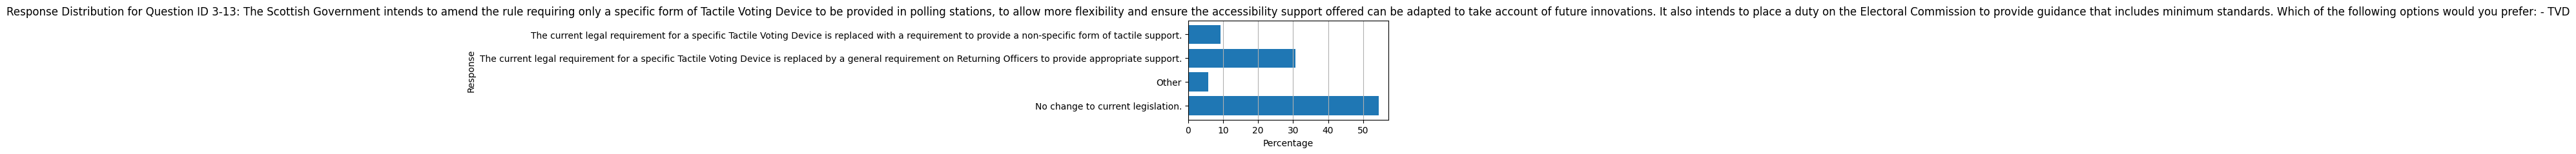

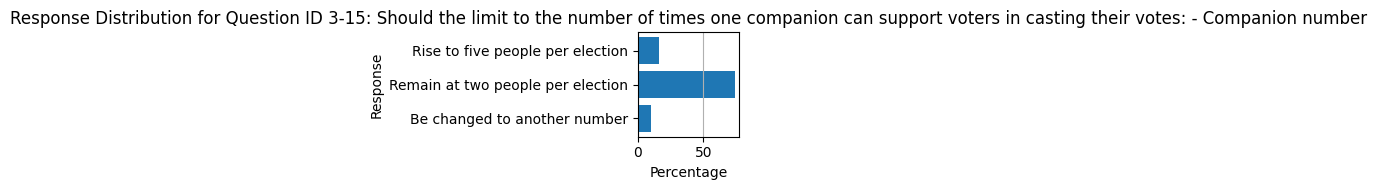

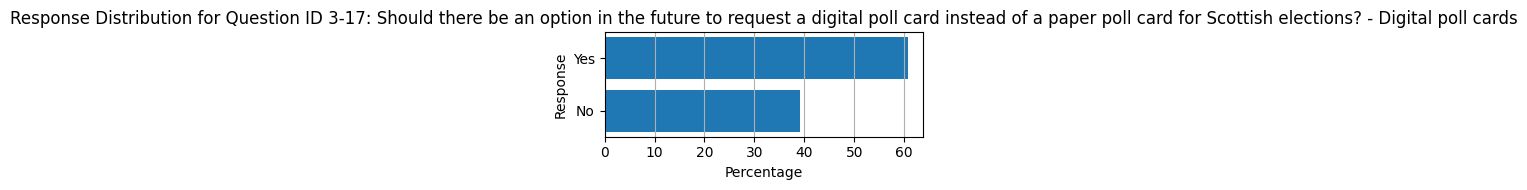

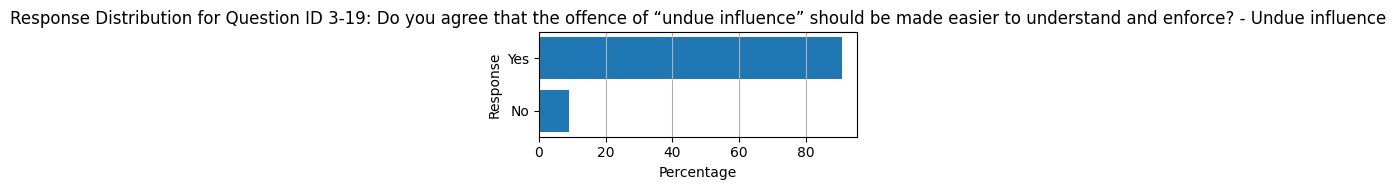

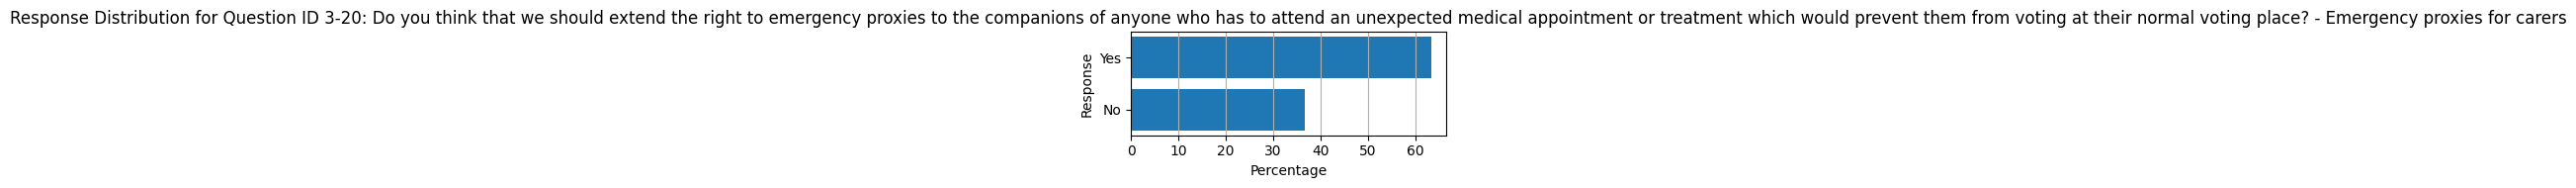

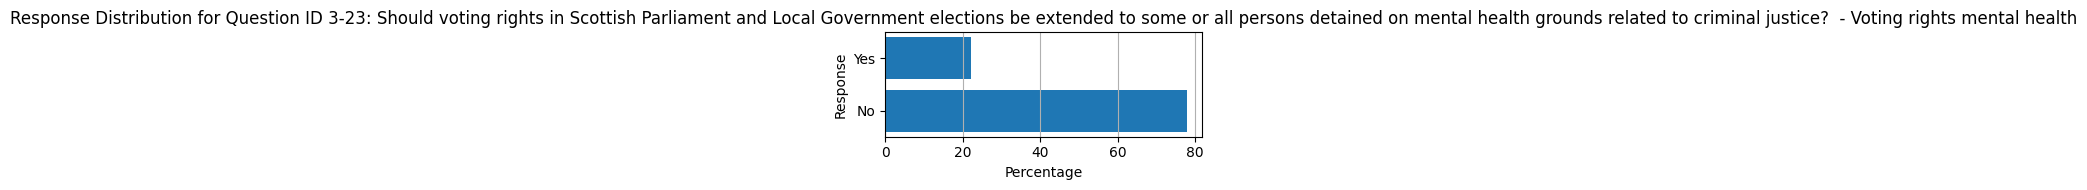

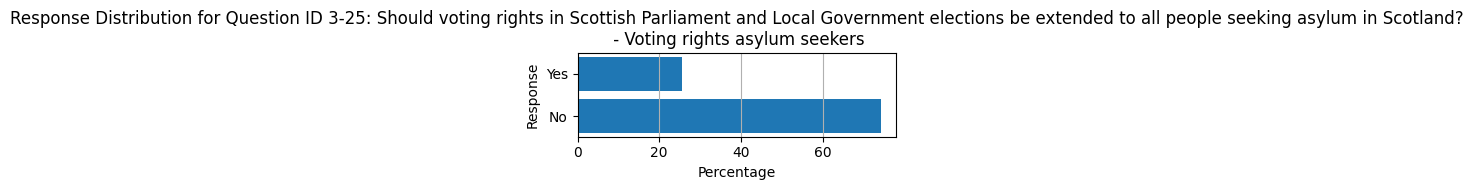

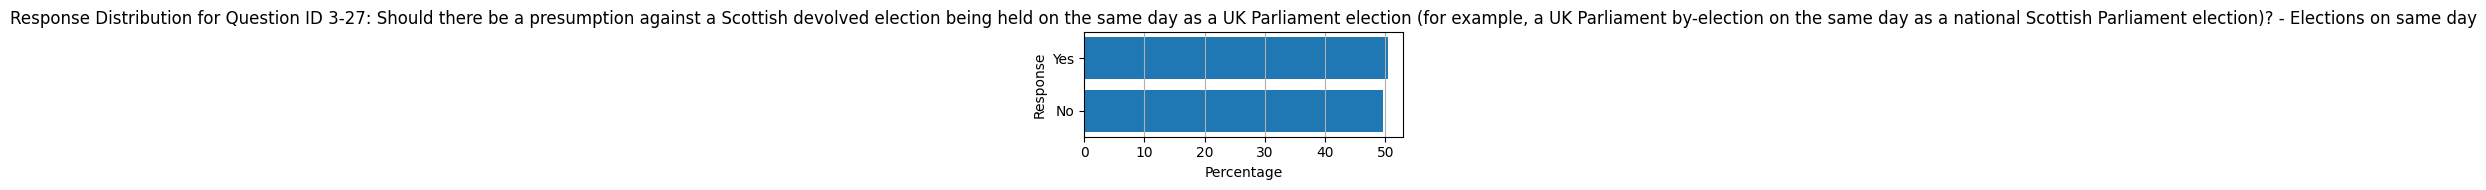

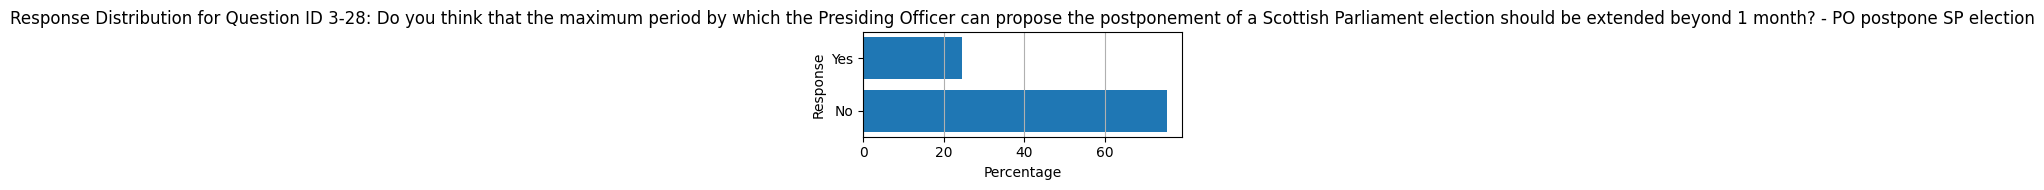

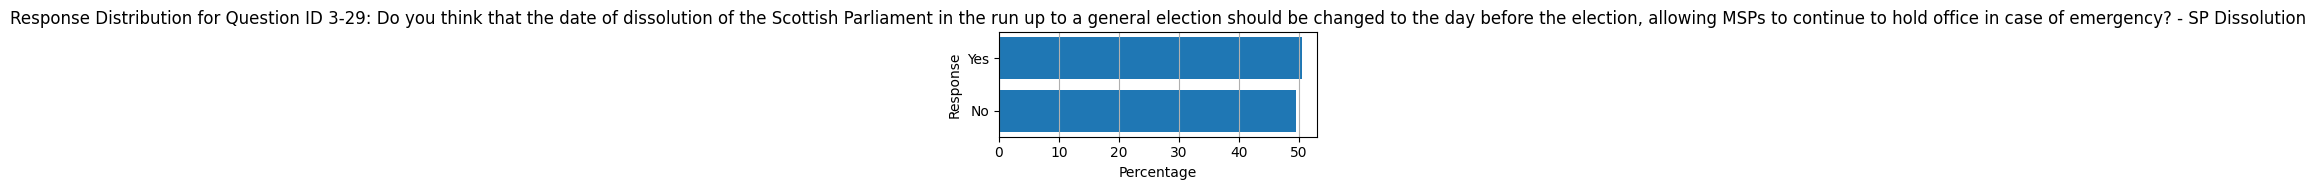

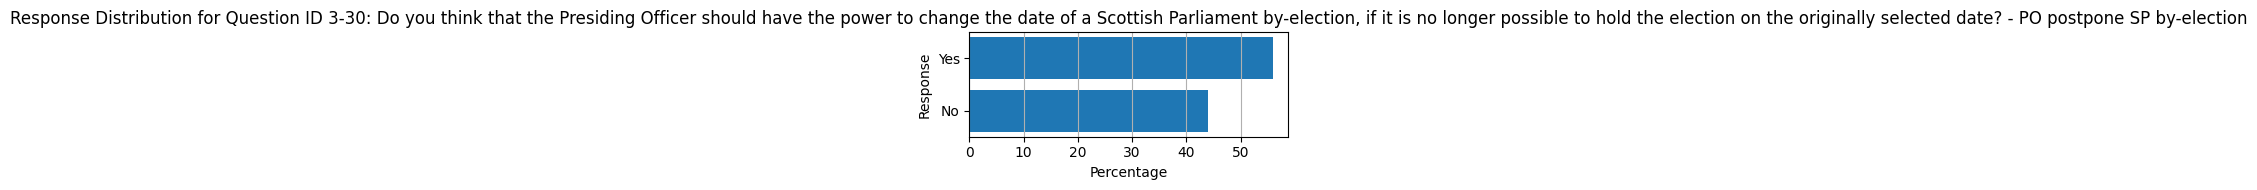

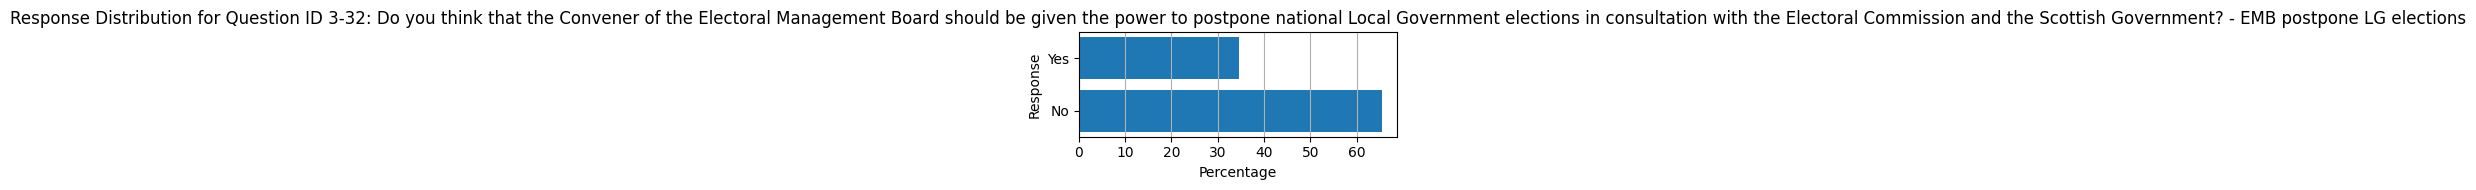

<ipython-input-34-f2dc4fd7c388>:39: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


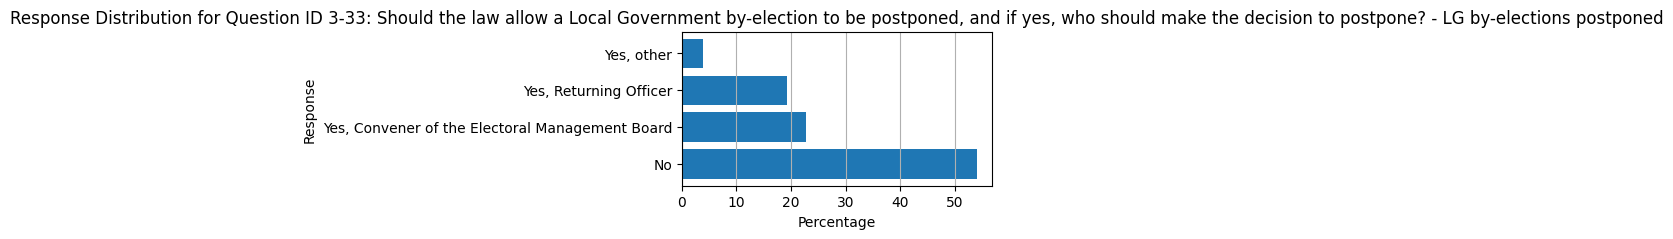

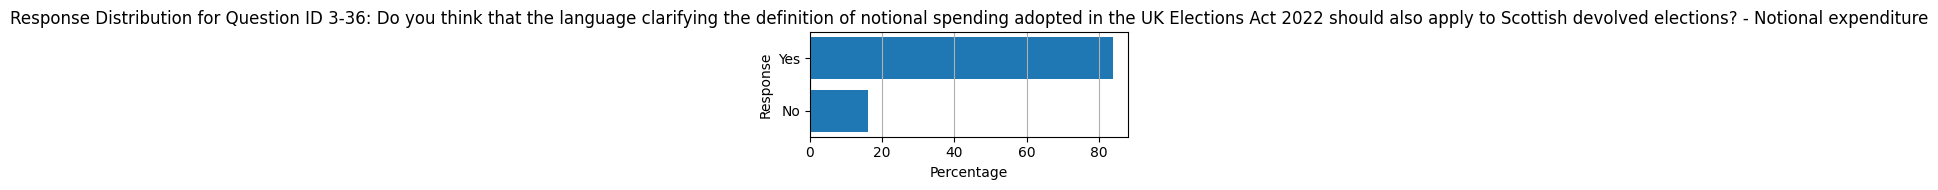

<ipython-input-34-f2dc4fd7c388>:39: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


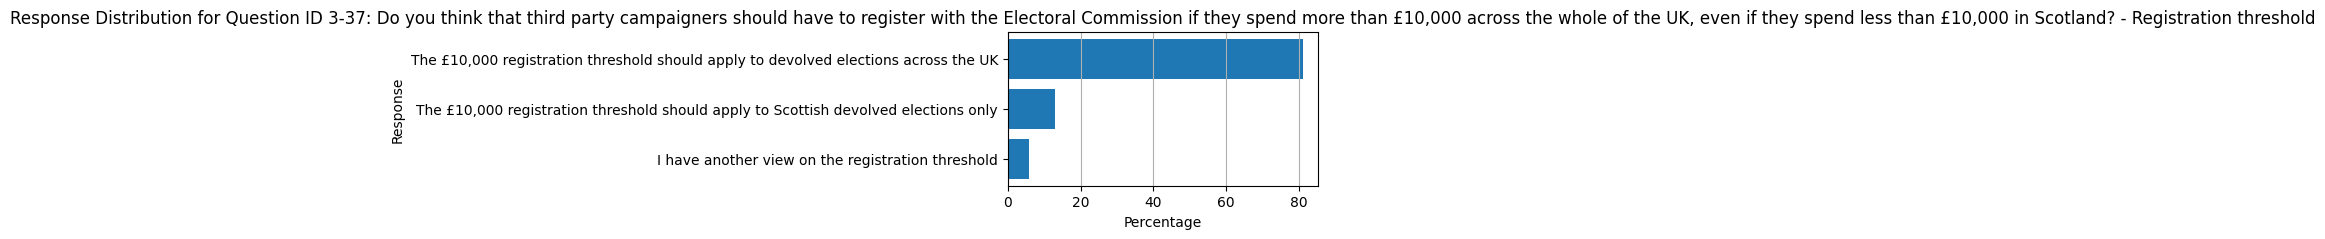

<ipython-input-34-f2dc4fd7c388>:39: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


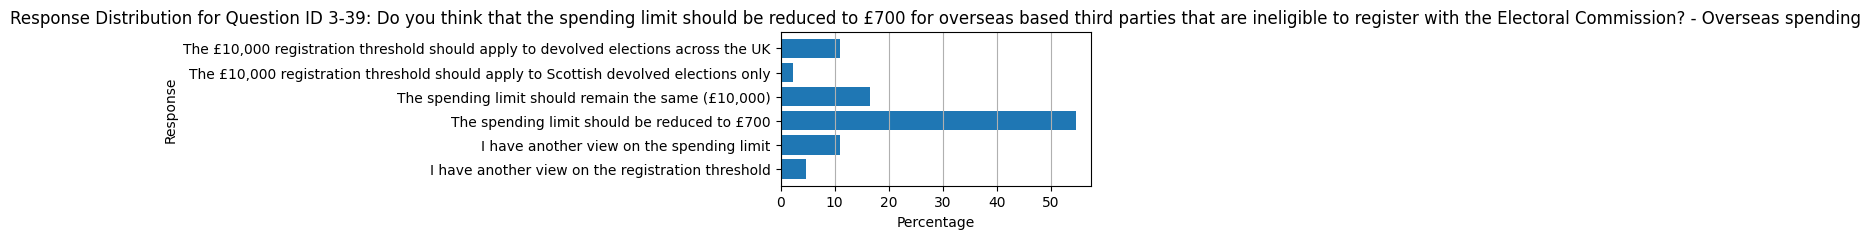

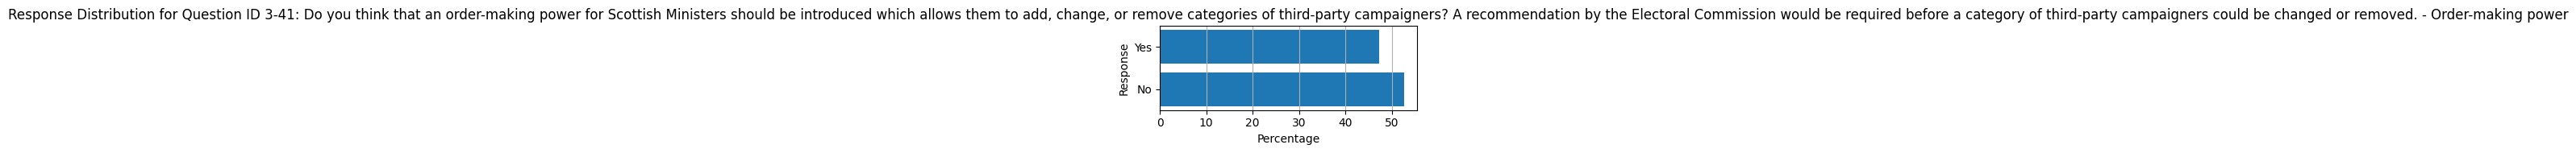

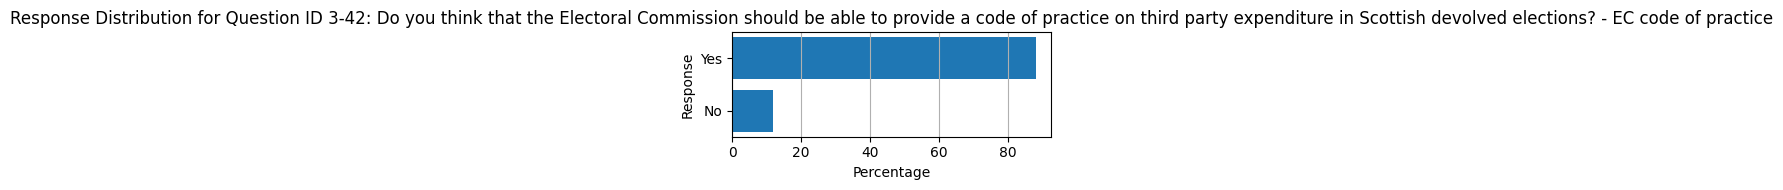

<ipython-input-34-f2dc4fd7c388>:39: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


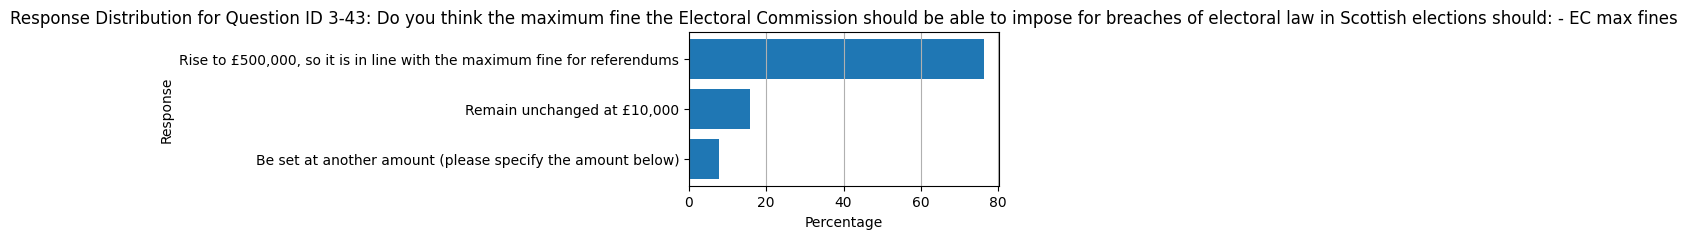

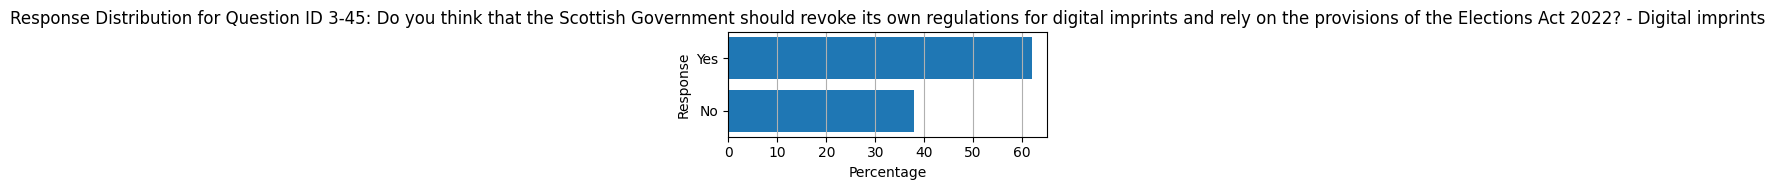

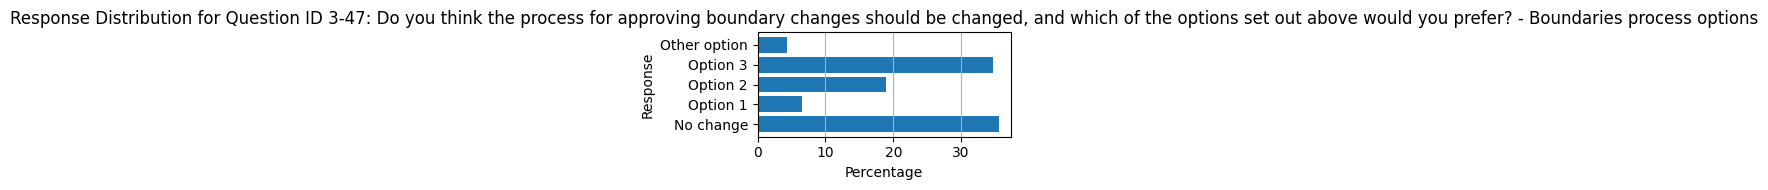

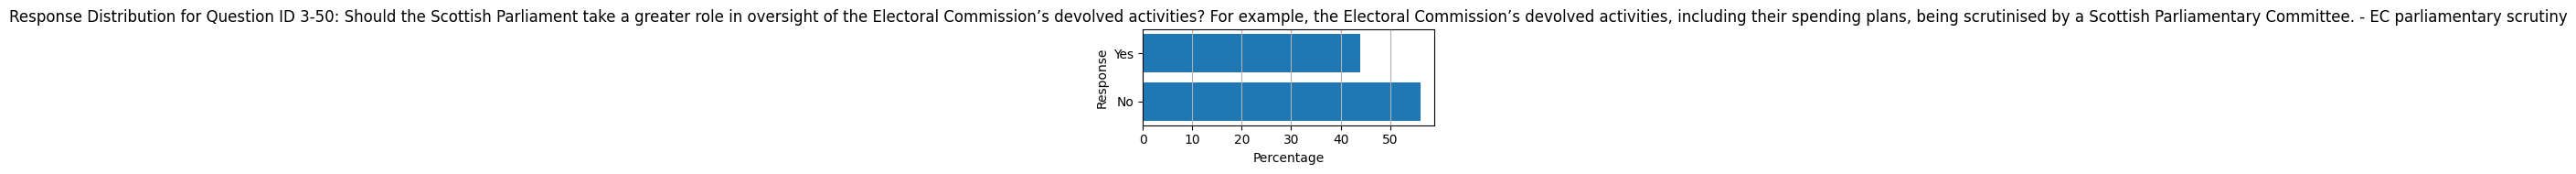

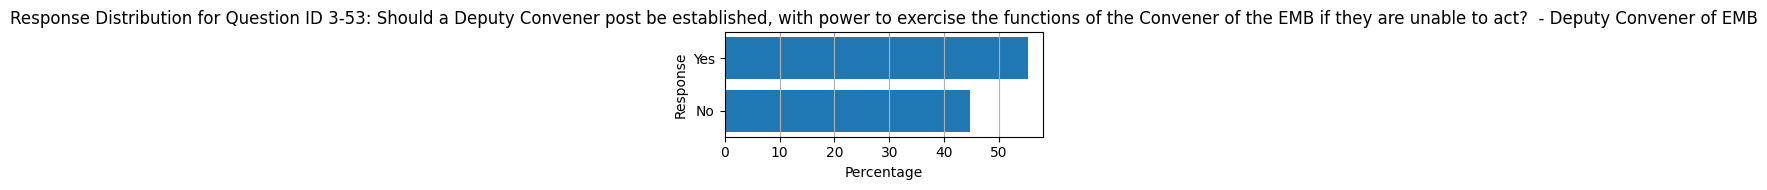

In [34]:
# Analyse the multiple choice questions for each consultation (only 2 and 3 have MCQs)
def analyse_mcqs():
    # Get only MCQs from each consultation
    cursor.execute('SELECT id, question FROM Question WHERE multiplechoice = 1 AND consultation_id=2')
    consultation_2_MCQs = cursor.fetchall()
    cursor.execute('SELECT id, question FROM Question WHERE multiplechoice = 1 AND consultation_id=3')
    consultation_3_MCQs = cursor.fetchall()

    # query to select mcq questions and responses
    query = """
    SELECT q.id AS question_id, res.response, r.id AS responder_id
    FROM Response res
    JOIN Question q ON res.question_id = q.id
    JOIN Responder r ON res.responder_id = r.id
    WHERE q.id = ?;
    """

    question_dict = dict()

    # For each MCQ, query the responses and load them into a pandas DataFrame
    for mcq_id, mcq_text in consultation_2_MCQs + consultation_3_MCQs:
        multiple_choice_df = pd.read_sql_query(query, conn, params=[mcq_id])
        grouped = multiple_choice_df.groupby(['responder_id', 'response']).size().unstack(fill_value=0)
        # Store the question text and the DataFrame together
        question_dict[mcq_id] = (mcq_text, grouped)

    # Analyse distribution of responses for each MCQ and plot the data
    for question_id, (question_text, df) in question_dict.items():
        response_counts = df.sum()  # Calculate the sum of each column to get the count of each response
        response_percentages = (response_counts / len(df)) * 100
        response_distribution_df = response_percentages.reset_index().rename(columns={'index': 'response', 0: 'percentage'})

        # Plot the response distribution for the current question (horizontal bar chart)
        plt.figure(figsize=(4, 2))
        plt.barh(response_distribution_df['response'], response_distribution_df['percentage'])
        plt.title(f"Response Distribution for Question ID {question_id}: {question_text}")
        plt.xlabel('Percentage')
        plt.ylabel('Response')
        plt.grid(axis='x')
        plt.tight_layout()
        plt.show()

analyse_mcqs()


# Deep Learning Analysis


### Text pre processing

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

# Custom stopwords that don't include negations like "not" or didn't so sentiment analysis is not impacted
stopwords = set([
    "a", "an", "the", "this", "that", "it", "is", "am", "are", "was", "were", "be", "being", "been",
    "have", "has", "had", "do", "does", "did", "doing", "and", "or", "but", "on", "in", "at", "by",
    "with", "of", "for", "as", "to", "from", "up", "down", "why", "how", "when", "where", "what",
    "should", "would", "could", "might", "may", "must", "shall", "can", "will", "i", "you", "he", "she",
    "we", "they", "my", "your", "his", "her", "its", "our", "their", "me", "him", "us", "them", "yours",
    "mine", "hers", "ours", "theirs"
])
lemmatizer = WordNetLemmatizer()

# Returns tokenised words in root form
def pre_process(text, stops=None):
    if text is None:
      return None
    punct = '!"#$%&\'()*+-/<=>?@[\\]^`{|}~.,'
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in punct])
    # Remove emojis
    text = demoji.replace(text,'')
    # Tokenize
    text = word_tokenize(text)
    if stops is not None:
      # Remove custom stopwords
      text = [w for w in text if not w in stops]
    # Lemmatize (reduce words to root form)
    text = [lemmatizer.lemmatize(token) for token in text]
    return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### Functions to retrieve data for open questions and responses

In [ ]:
# Get only open questions from a consultation
def get_open_questions(consultation_num, conn, cursor):
  query = "SELECT id FROM Question WHERE multiplechoice IS NOT 1 AND consultation_id=?"
  cursor.execute(query, (consultation_num,))
  open_qs = [x[0] for x in cursor.fetchall()]
  return open_qs

# Get all responses to a question
def get_responses_to_question(question_id):
  query = 'SELECT id, response FROM Response WHERE question_id = ?'
  cursor.execute(query, (question_id,))
  return [(x[0],x[1]) for x in cursor.fetchall()]

# Return dictionary of question id, response id and response for a list of question ids
def get_open_responses(questions):
  query = """
  SELECT q.id AS question_id, q.question, res.id, res.response, r.id AS responder_id
  FROM Response res
  JOIN Question q ON res.question_id = q.id
  JOIN Responder r ON res.responder_id = r.id
  WHERE q.id = ? AND res.response IS NOT NULL;
  """

  response_data_dict = dict() # To store all responses for all consultations

  # For each question, query responses and load them into a list of dictionaries
  for q in questions:
      cursor.execute(query, (q,))
      responses = cursor.fetchall()

      response_list = []
      for response in responses:
          response_dict = {
              'question_id': response[0],
              'response_id': response[2],
              'response': response[3],
          }
          response_list.append(response_dict)

      response_data_dict[q] = response_list

  return response_data_dict

## Sentiment Analysis

Several models will be compared against human sentiment values for a random set of responses from the consultations. The most accurate and efficient model will then be used for assigning sentiment values for all the responses in the dataset.  

### Compare and validate sentiment values

---



Get open ended questions into a dictionary and sample questions to manually analyse.

In [ ]:
vs_analyzer = SentimentIntensityAnalyzer() # Vader Sentiment

# Roberta Model
roberta_model = "cardiffnlp/twitter-roberta-base-sentiment"
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_model)
r_model = AutoModelForSequenceClassification.from_pretrained(roberta_model)

# Distilbert Model
distilbert_model = "lxyuan/distilbert-base-multilingual-cased-sentiments-student"
distilbert_tokenizer = AutoTokenizer.from_pretrained(distilbert_model)
d_model = AutoModelForSequenceClassification.from_pretrained(distilbert_model)
distilbert_classifier = TextClassificationPipeline(model=d_model, tokenizer=distilbert_tokenizer, return_all_scores=True, device=0)

# Parameters for models
tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512}

# Get responses to all open questions
questions = get_open_questions(1, conn, cursor)
responses_dict = get_open_responses(questions)

# Download label mapping (negative, positive, neutral)
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# Open the existing CSV file with human sentiment values
input_file_path = '/content/drive/MyDrive/DecodingDemocracy/sample_sentiment_values.csv'
df = pd.read_csv(input_file_path)

# Add models' sentiment columns to the DataFrame
roberta_sentiments = []
vader_sentiments = []
textblob_sentiments = []
distilbert_sentiments = []

vader_differences = []
roberta_differences = []
textblob_differences = []
distilbert_differences = []

for idx, ans in enumerate(df['answer']):
    if ans is not None:
      ans = " ".join(pre_process(ans))
      # vader sentiment analysis
      vs = vs_analyzer.polarity_scores(ans)
      vader_sentiments.append(round(vs['compound'],3))
      # texblob sentiment analysis
      tb = TextBlob(ans)
      textblob_sentiments.append(round(tb.sentiment.polarity,3))
      # roberta sentiment analysis
      encoded_input = roberta_tokenizer(ans, return_tensors='pt', max_length=512, truncation=True)
      output = r_model(**encoded_input)
      scores = output[0][0].detach().numpy()
      scores = softmax(scores)
      ranking = np.argsort(scores)
      ranking = ranking[::-1]
      score, label = 0, ""

      # get roberta scores
      for i in range(scores.shape[0]):
          l = labels[ranking[i]]
          s = scores[ranking[i]]
          if l == "negative":
            score -= abs(s)
          elif l == "positive":
            score += abs(s)
      roberta_sentiments.append(round(score,3))

      # distilbert sentiment analysis
      outputs = distilbert_classifier(ans, **tokenizer_kwargs)[0]
      dist_score = 0
      # get distilbert scores
      for o in outputs:
        if o['label'] == "negative":
          dist_score -= abs(o['score'])
        elif o['label'] == "positive":
          dist_score += abs(o['score'])
      distilbert_sentiments.append(round(dist_score,3))

      # Calculate absolute differences between model predictions and human sentiment
      vader_diff = abs(vader_sentiments[idx] - df['human'][idx])
      roberta_diff = abs(roberta_sentiments[idx] - df['human'][idx])
      textblob_diff = abs(textblob_sentiments[idx] - df['human'][idx])
      distilbert_diff = abs(distilbert_sentiments[idx] - df['human'][idx])

      # Append differences to lists
      vader_differences.append(vader_diff)
      roberta_differences.append(roberta_diff)
      textblob_differences.append(textblob_diff)
      distilbert_differences.append(distilbert_diff)

# Calculate average absolute differences
avg_vader_difference = sum(vader_differences) / len(vader_differences)
avg_roberta_difference = sum(roberta_differences) / len(roberta_differences)
avg_textblob_difference = sum(textblob_differences) / len(textblob_differences)
avg_distilbert_difference = sum(distilbert_differences) / len(distilbert_differences)

print(f'Average Vader Difference: {avg_vader_difference:.3f}')
print(f'Average Roberta Difference: {avg_roberta_difference:.3f}')
print(f'Average TextBlob Difference: {avg_textblob_difference:.3f}')
print(f'Average Distilbert Difference: {avg_distilbert_difference:.3f}')

df['vader'] = vader_sentiments
df['roberta'] = roberta_sentiments
df['textblob'] = textblob_sentiments
df['distilbert'] = distilbert_sentiments

# Overwrite the CSV file with updated data
df.to_csv('/content/drive/MyDrive/DecodingDemocracy/sample_sentiment_values.csv', index=False, encoding='utf-8')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

KeyboardInterrupt: 

### Compare Human sentiment analysis with Vader, TextBlob, RoBERTa and Distilbert to decide which one to use

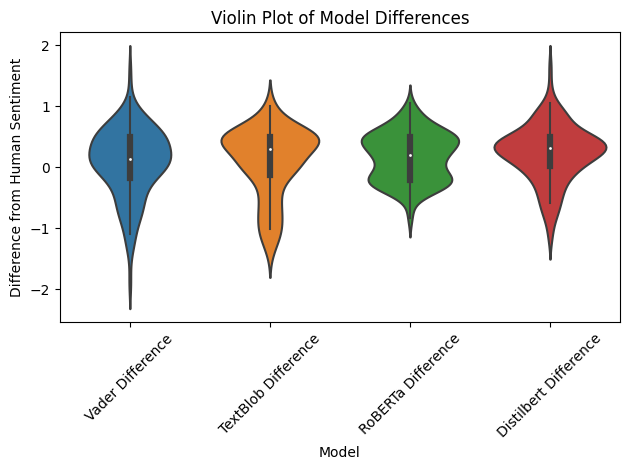

In [ ]:
# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/DecodingDemocracy/sample_sentiment_values.csv')

# Calculate difference
df['Vader Difference'] = df['human'] - df['vader']
df['TextBlob Difference'] = df['human'] - df['textblob']
df['RoBERTa Difference'] = df['human'] - df['roberta']
df['Distilbert Difference'] = df['human'] - df['distilbert']

# Prepare data for plotting
plot_data = pd.melt(df,
                    value_vars=['Vader Difference', 'TextBlob Difference', 'RoBERTa Difference', 'Distilbert Difference'],
                    var_name='Model', value_name='Difference')

# Violin Plot

sns.violinplot(x='Model', y='Difference', data=plot_data)
plt.title('Violin Plot of Model Differences')
plt.ylabel('Difference from Human Sentiment')
plt.xlabel('Model')
plt.xticks(rotation=45)  # Rotates labels by 45 degrees

plt.tight_layout()
plt.show()


From the violin plots, it seems that RoBERTa produced the most accurate sentiment values, when compared with the human values we assigned. The roberta violin plot is wider around zero values showing most of the difference in values between human and roberta sentiment was close to 0. However, since it is a very large and slow model, we will use the more efficient distilbert model for our sentiment analysis, which still produces similar results.

### Distilbert sentiment analysis

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student")
model = AutoModelForSequenceClassification.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student")

distilbert_classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True, device=0)

# Create a function to analyze sentiments and update sentiment_value in the "Response" table
def analyze_sentiments(responses_dict, batch_size=32, query='UPDATE Response SET sentiment_value = ? WHERE id = ?'):
    results = defaultdict(lambda: {'negative': 0, 'neutral': 0, 'positive': 0})
    for q, responses in tqdm(responses_dict.items()):
        tokenizer_kwargs = {'padding': True, 'truncation': True, 'max_length': 512}
        for res in responses:
            response = res.get('response')
            if response is None:
              continue
            response = " ".join(pre_process(response))
            id = res.get('response_id')
            outputs = distilbert_classifier(response, **tokenizer_kwargs)[0]
            sentiment_value = 0
            # get sentiment scores
            for o in outputs:
                results[q][o['label']] += o['score']
                if o['label'] == "negative":
                  sentiment_value -= abs(o['score'])
                elif o['label'] == "positive":
                  sentiment_value += abs(o['score'])
            rounded = round(sentiment_value,3)
            # Update sentiment_value in the "Response" table using SQL
            cursor.execute(query, (rounded, id,))
            conn.commit()

    return results

# Visualization of sentiment with a bar chart showing each category
def plot_sentiment_distribution(sentiment_summary, analysis_type):
    for k, sentiment_count in sentiment_summary.items():
        categories = ['negative', 'neutral', 'positive']
        counts = [sentiment_count[category] for category in categories]
        plt.bar(categories, counts, color=['red', 'grey', 'green'])
        plt.title(f'{analysis_type} Sentiment Distribution for Question {k}')
        plt.ylabel('Count')
        plt.xticks(rotation=45)  # Rotates labels by 45 degrees
        plt.show()

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Now we can use Distilbert to assign sentiment values for every response in every consultation.

### Consultation 1 Sentiment Analysis


  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(

100%|██████████| 5/5 [08:05<00:00, 97.11s/it]


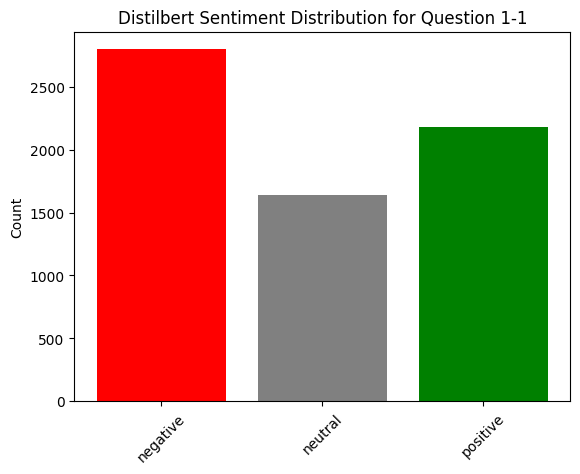

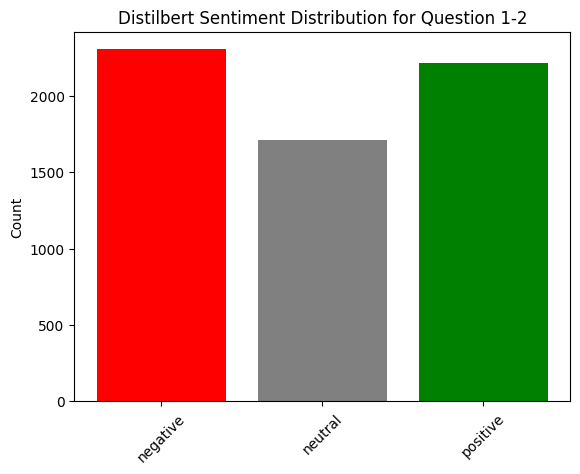

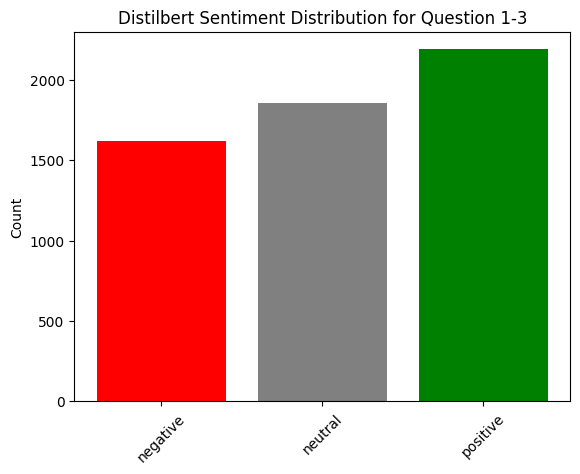

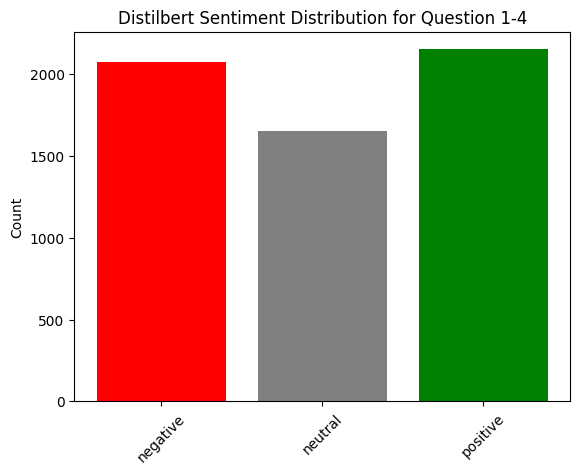

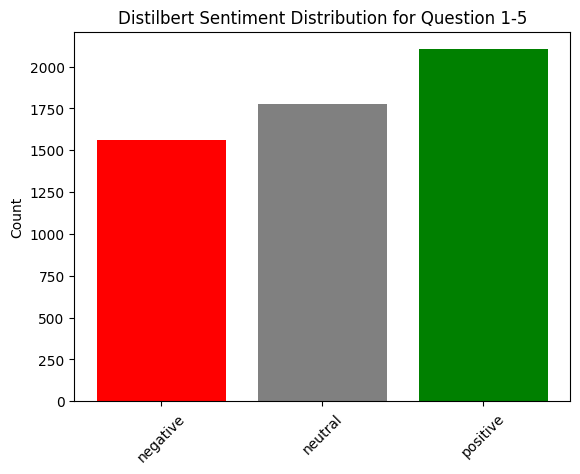

In [ ]:
questions = get_open_questions(1, conn, cursor)
responses_dict = get_open_responses(questions)
# Call the function to analyze sentiments in batches
distilbert_sentiment_summary = analyze_sentiments(responses_dict)
plot_sentiment_distribution(distilbert_sentiment_summary, 'Distilbert')
!cp db.sqlite /content/drive/MyDrive/DecodingDemocracy/

### Consultation 2 Sentiment Analysis


  0%|          | 0/23 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(

100%|██████████| 23/23 [01:57<00:00,  5.11s/it]


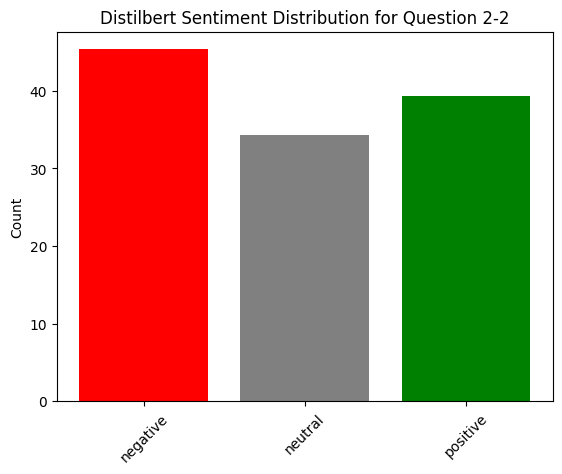

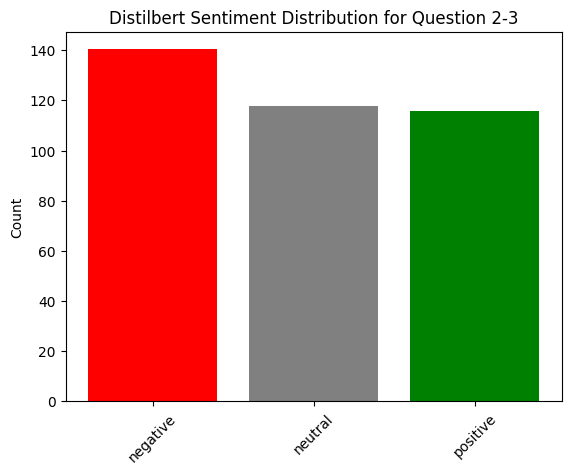

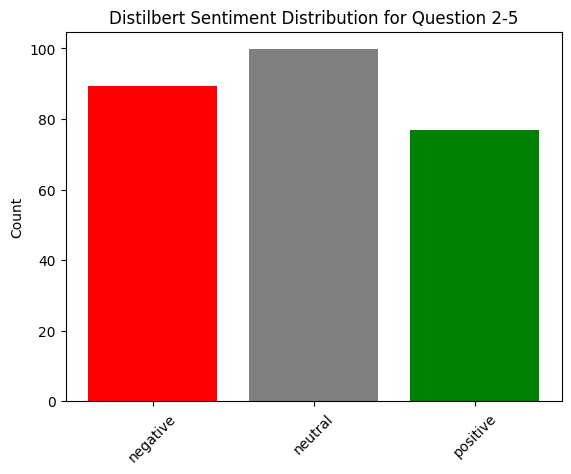

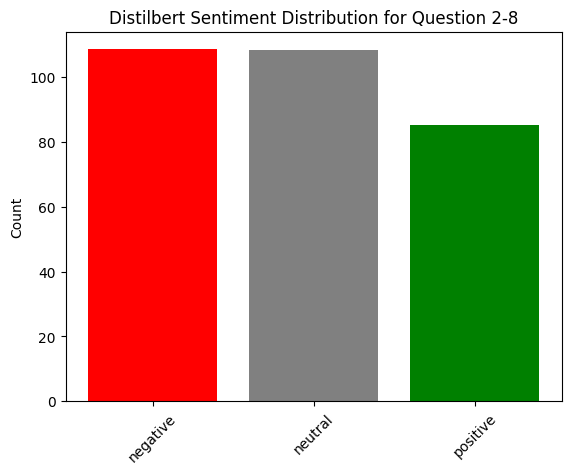

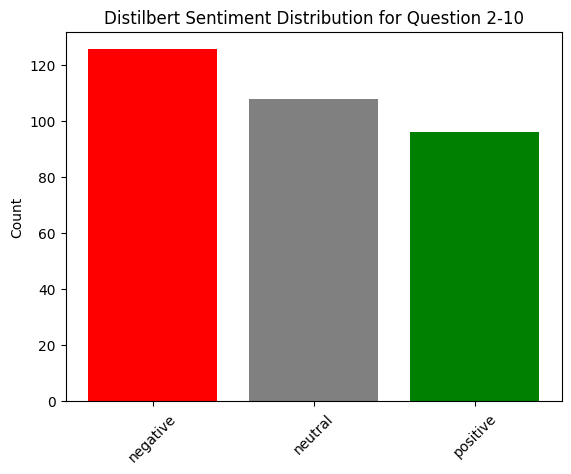

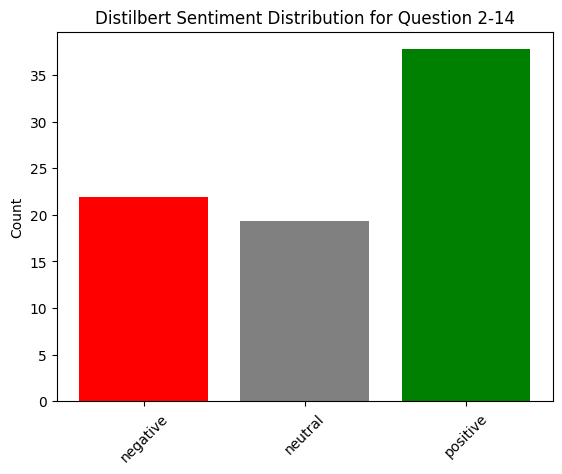

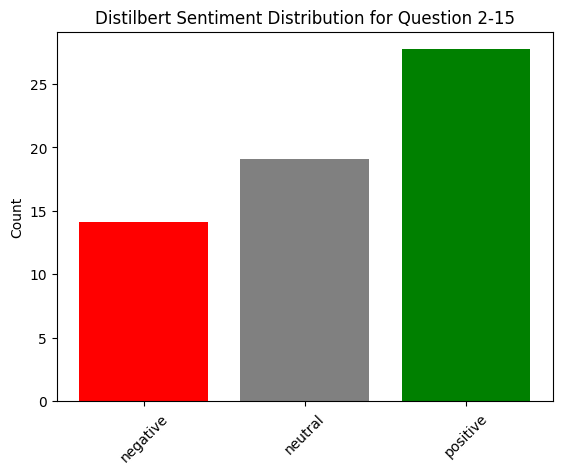

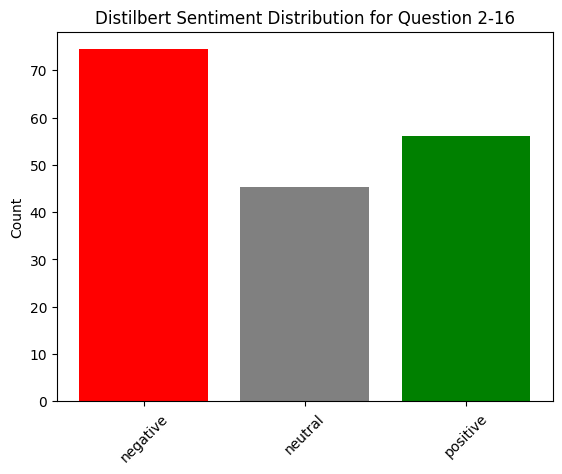

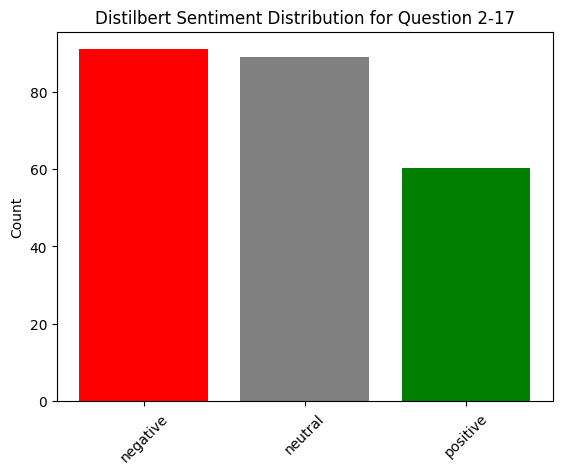

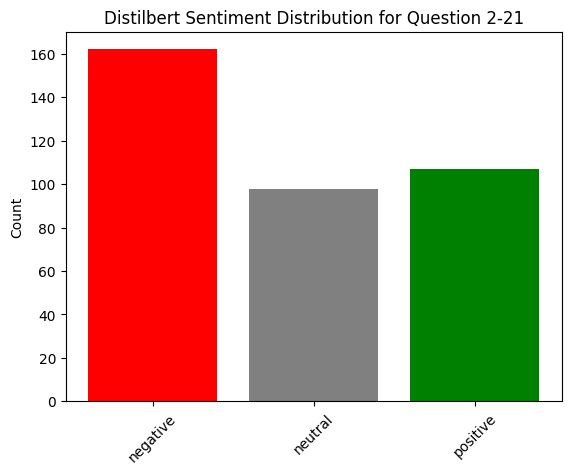

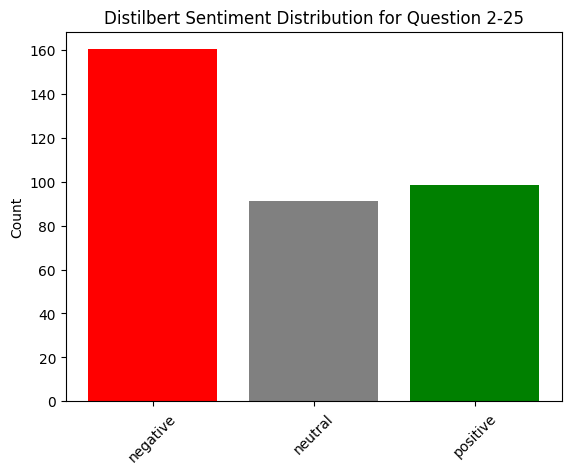

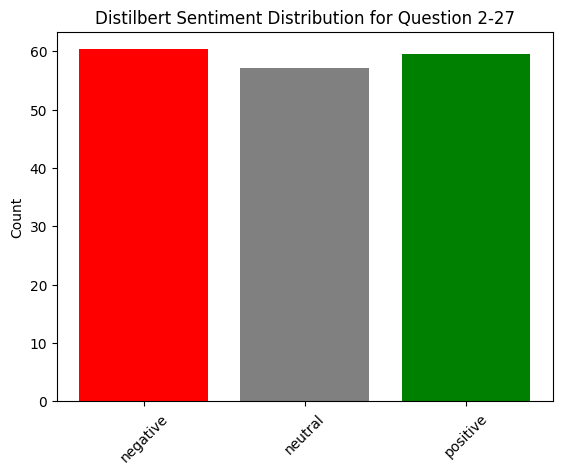

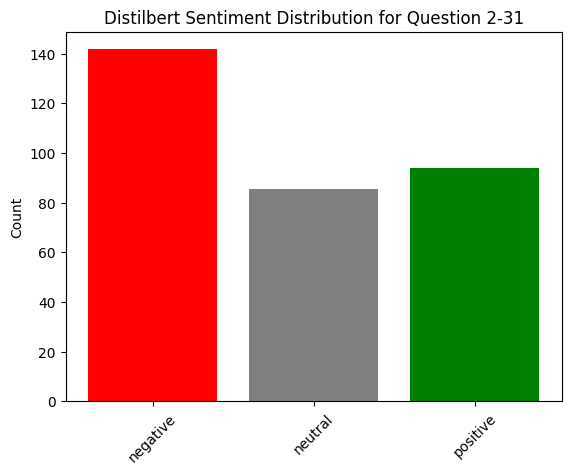

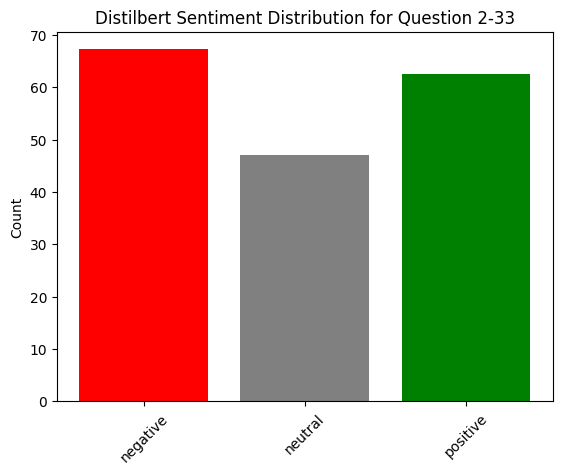

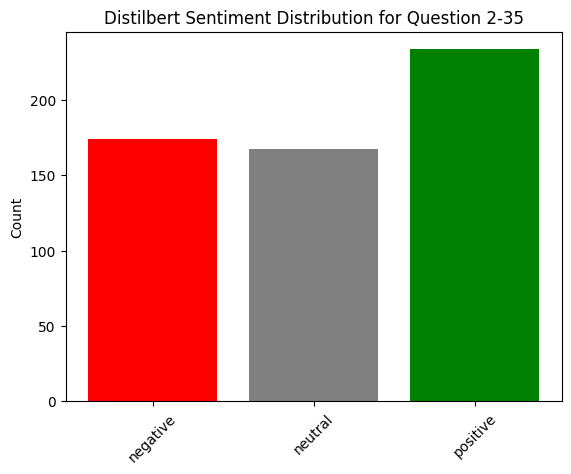

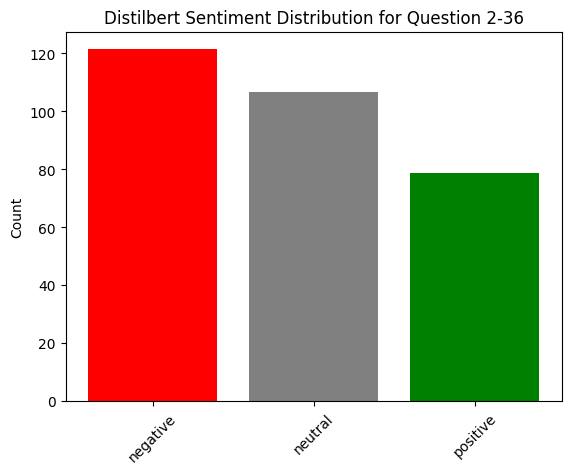

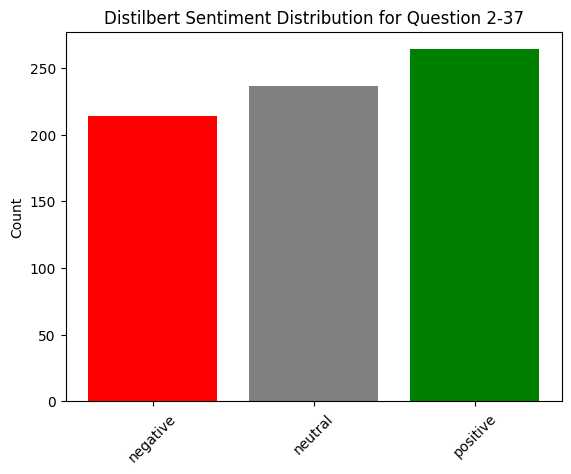

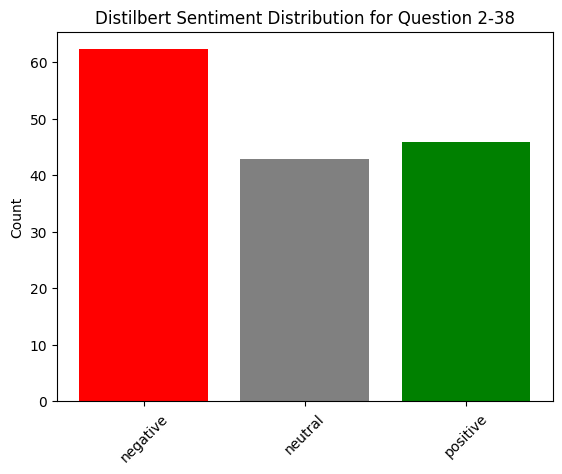

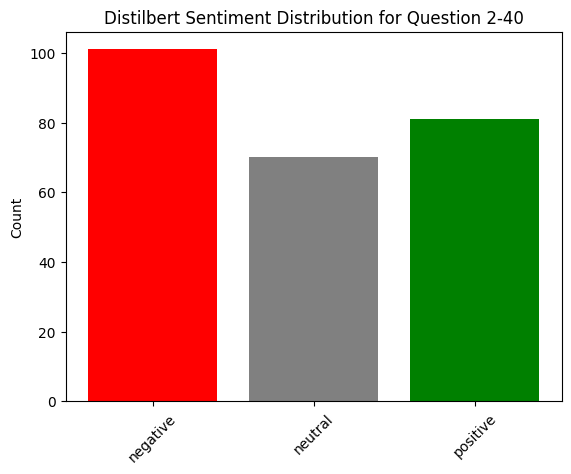

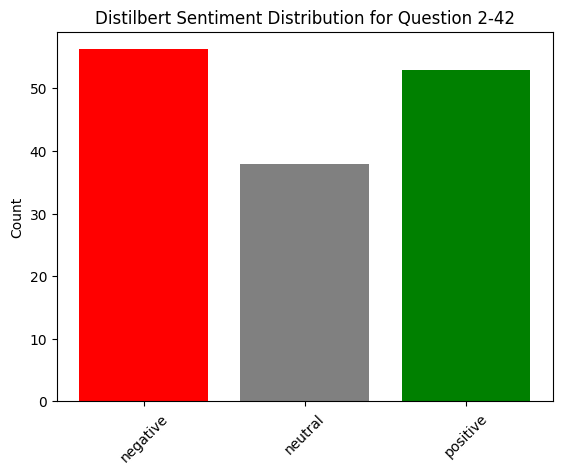

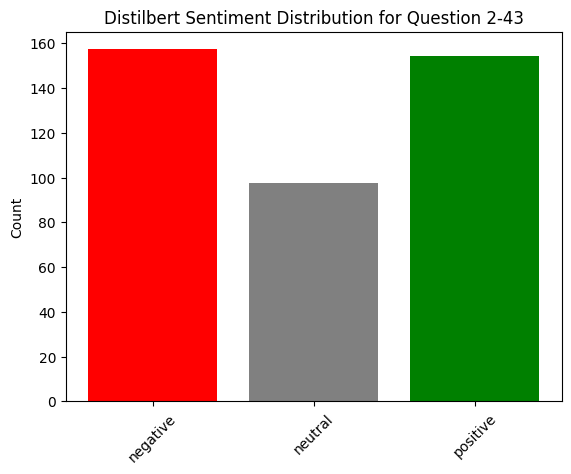

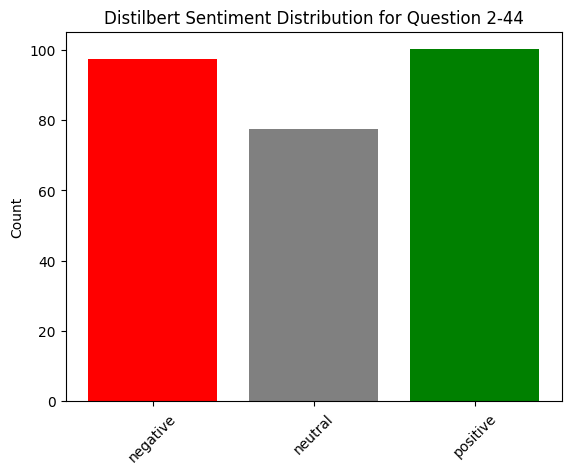

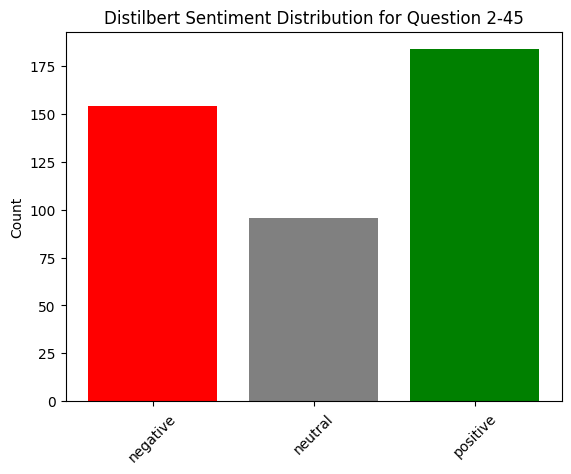

In [ ]:
questions = get_open_questions(2, conn, cursor)
responses_dict = get_open_responses(questions)
# Call the function to analyze sentiments in batches
distilbert_sentiment_summary = analyze_sentiments(responses_dict)
plot_sentiment_distribution(distilbert_sentiment_summary, 'Distilbert')
!cp db.sqlite /content/drive/MyDrive/DecodingDemocracy/

### Consultation 3 Sentiment Analysis


100%|██████████| 23/23 [00:49<00:00,  2.14s/it]


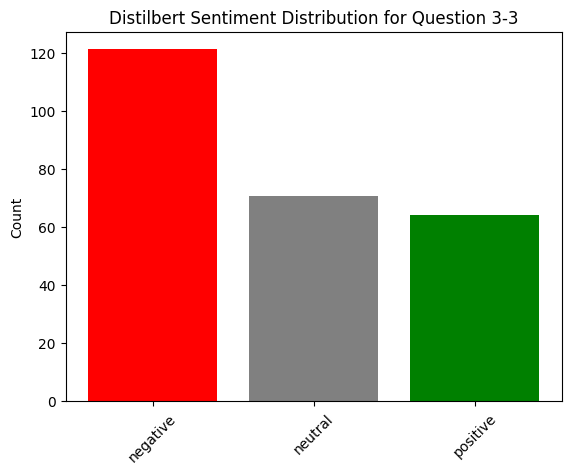

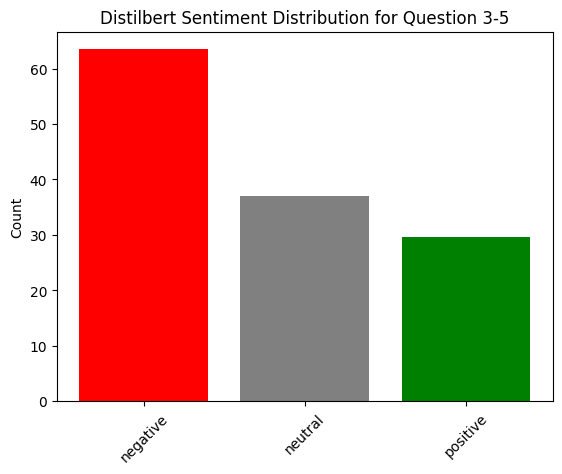

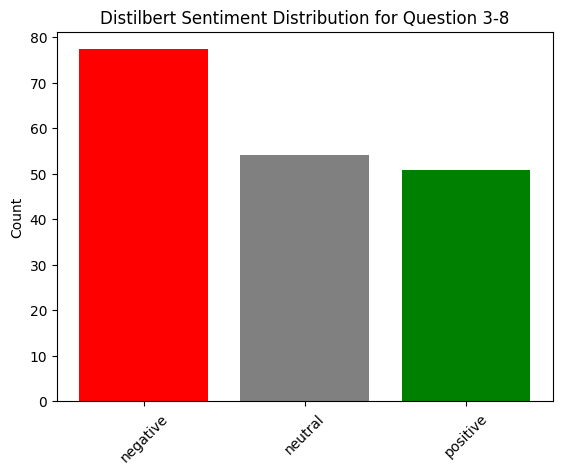

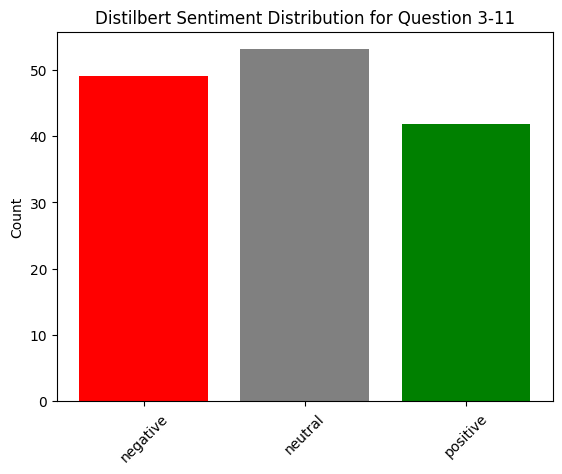

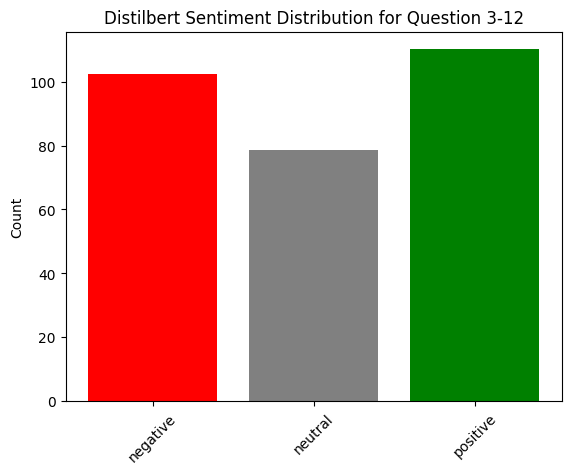

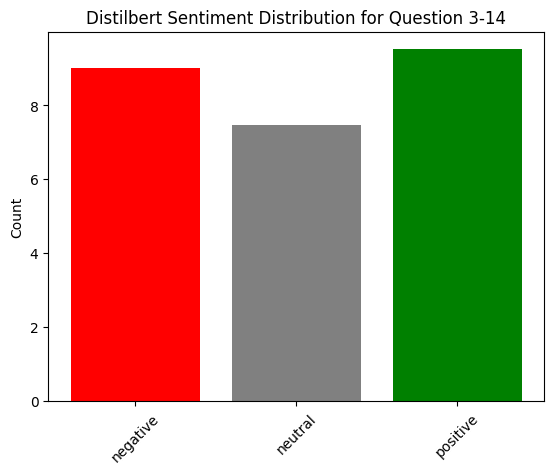

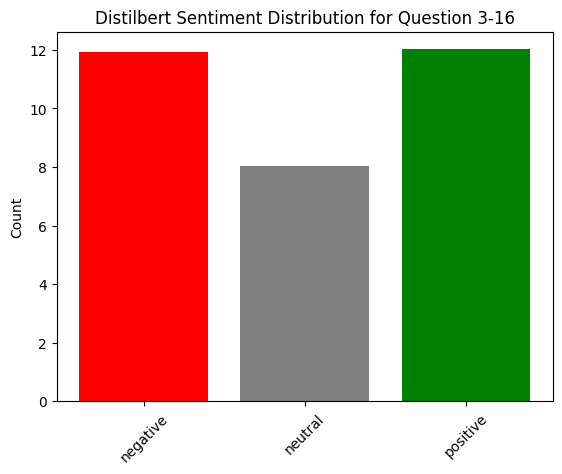

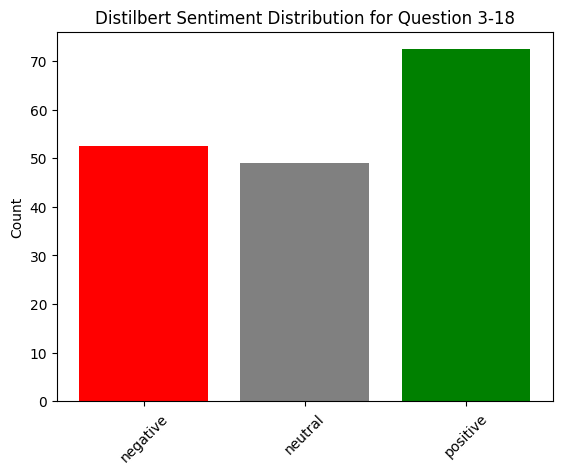

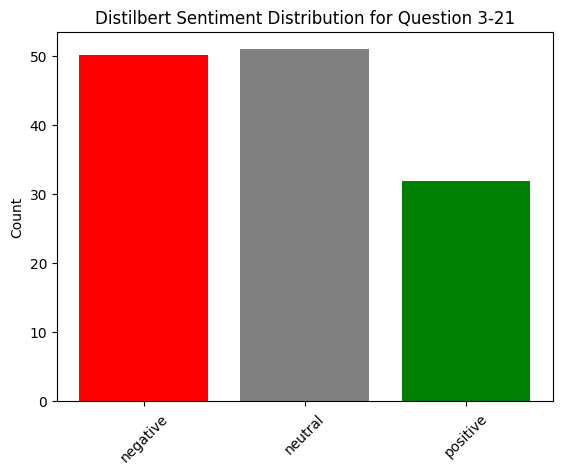

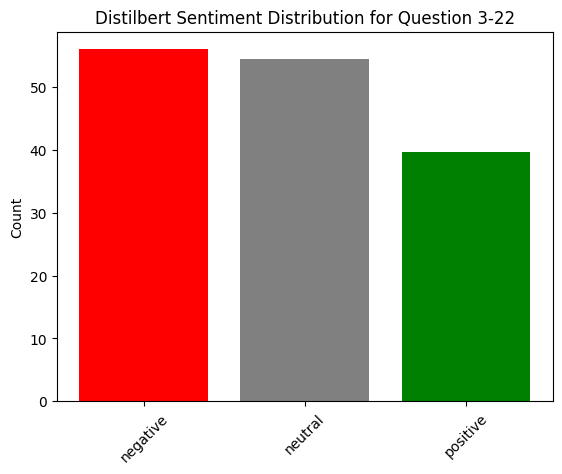

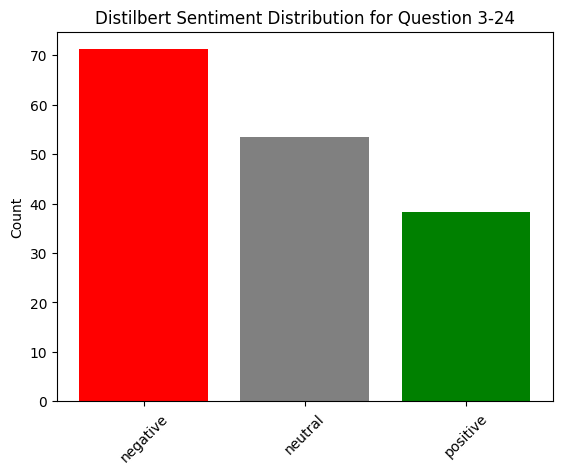

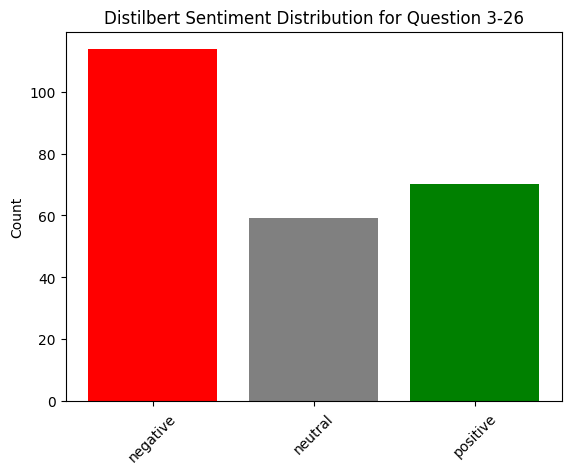

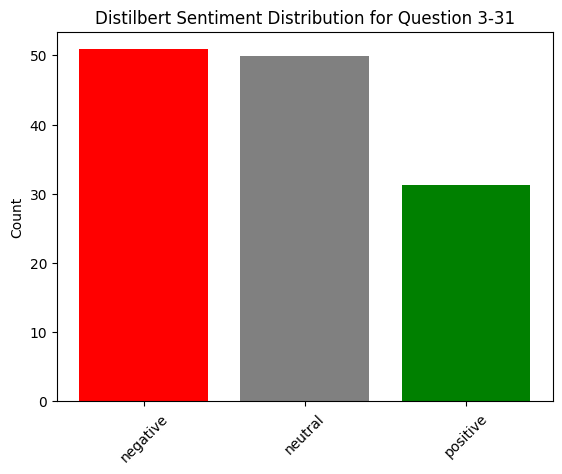

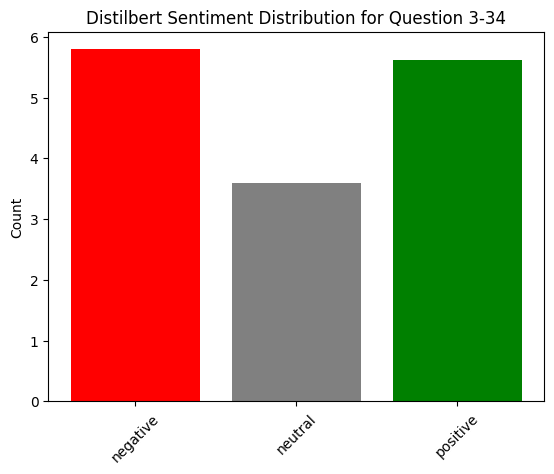

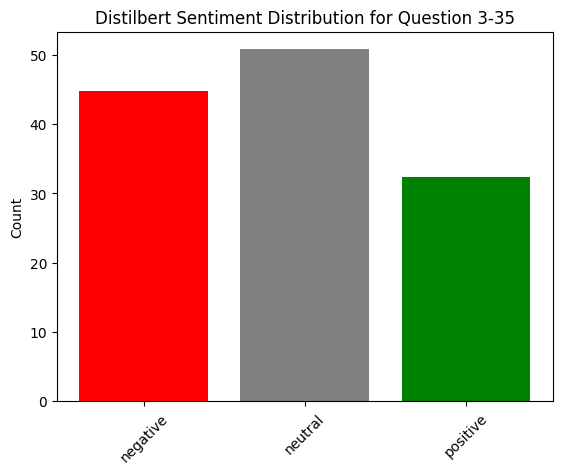

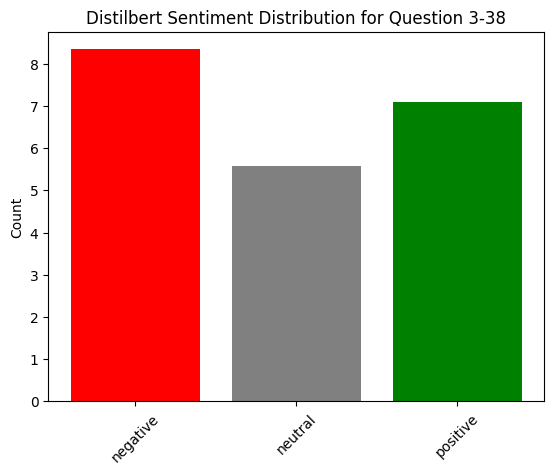

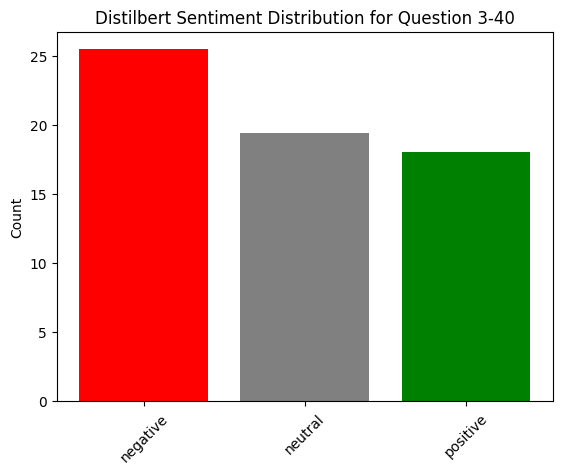

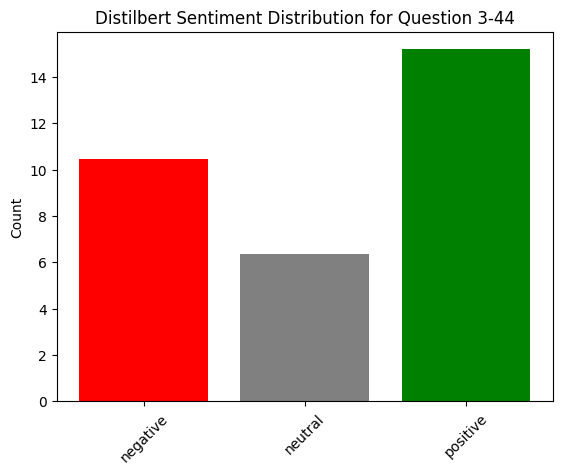

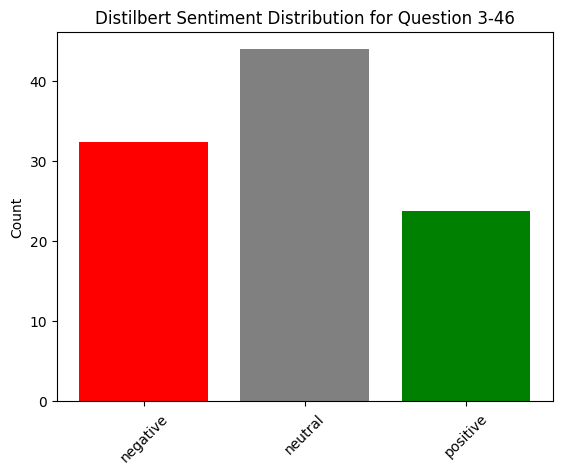

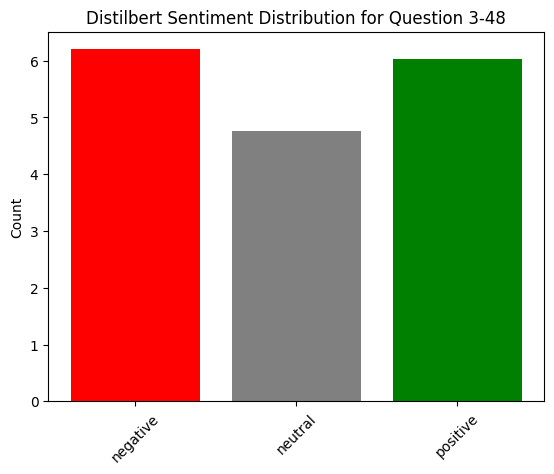

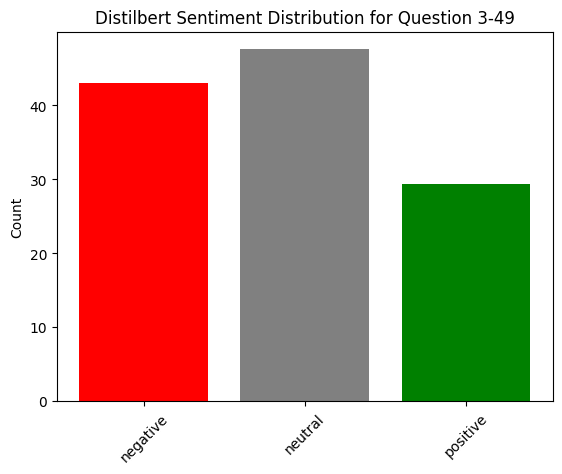

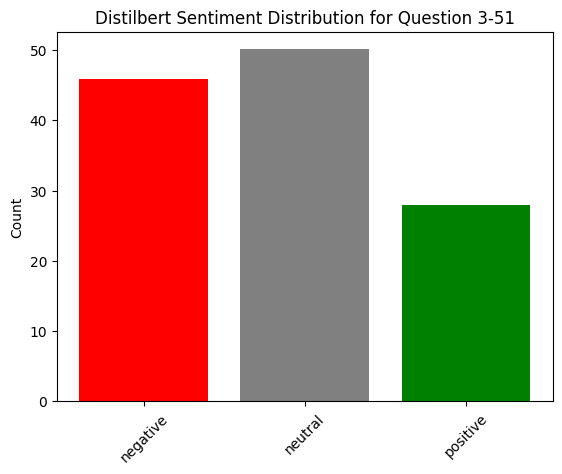

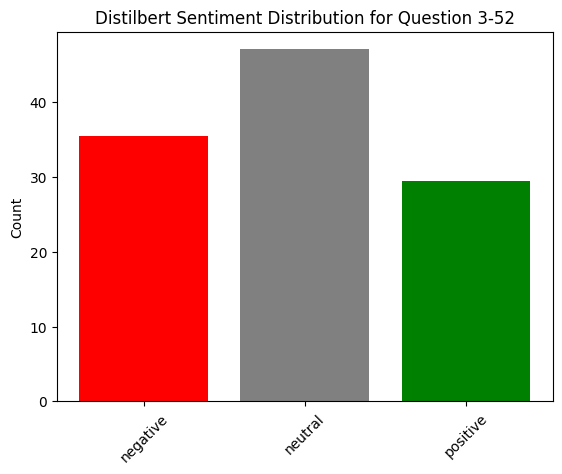

In [ ]:
questions = get_open_questions(3, conn, cursor)
responses_dict = get_open_responses(questions)
# Call the function to analyze sentiments in batches
distilbert_sentiment_summary = analyze_sentiments(responses_dict)
plot_sentiment_distribution(distilbert_sentiment_summary, 'Distilbert')
!cp db.sqlite /content/drive/MyDrive/DecodingDemocracy/

## Topic modelling

Latent Dirichlet Allocation (LDA) is used for topic modelling because it is able to efficiently handle large document collections and use unsupervised learning to discover latent topics without any prior knowledge or labeled data. This makes it well-suited for exploratory analysis of consultation responses where the topics are initially unknown. The output of LDA is also very interpretable, as it gives the most relevant words for each topic.

### Clustering Functions

Similar responses are grouped from the public consultations with clustering. Use a pre-trained language model to generate embeddings for each response, capturing its meaning and context.

Next, responses are clustered to automatically group similar items together based on how similar their embeddings are.

In [ ]:
def generate_embeddings(responses, model):
    # Convert lists of tokens back to strings
    responses_str = [' '.join(tokens) for tokens in responses]

    # Generate embeddings
    embeddings = model.encode(responses_str, batch_size = 8, show_progress_bar = True, convert_to_tensor=True)

    # Convert embeddings to numpy and normalize
    embeddings_np = embeddings.cpu().numpy()
    embeddings_np = embeddings_np / np.linalg.norm(embeddings_np, axis=1, keepdims=True)

    return embeddings_np

def cluster_sentences(embeddings, responses):
    # Perform k-mean clustering
    clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=3.5)
    clustering_model.fit(embeddings)
    cluster_assignment = clustering_model.labels_

    clustered_sentences = {}
    for sentence_id, cluster_id in enumerate(cluster_assignment):
        if cluster_id not in clustered_sentences:
            clustered_sentences[cluster_id] = []

        clustered_sentences[cluster_id].append(responses[sentence_id])

    return clustered_sentences, cluster_assignment

def get_cluster_labels(clustered_sentences):
    cluster_labels = {}
    for cluster_id, sentences in clustered_sentences.items():
        # Use the first sentence or a more sophisticated method to label the cluster
        cluster_labels[cluster_id] = sentences[0]  # This is a simplification
    return cluster_labels

### Topic Assignment Functions

From the clusters generated, topics are found using LDA as described earlier. This involves unsupervised learning technique to assign meaningful topic labels to each cluster.

In [ ]:
def get_top_words(topic, lda_model, num_words, dictionary):
    # Get the top words for the topic
    top_words = {dictionary[word_id]: value for word_id, value in lda_model.get_topic_terms(topic, topn=num_words)}
    return top_words

def plot_top_words(topic, top_words):
    plt.figure(figsize=(5,5))
    plt.title(f"Top words in topic {topic}")
    plt.bar(range(len(top_words)), list(top_words.values()), align='center')
    plt.xticks(range(len(top_words)), list(top_words.keys()), rotation='vertical')
    plt.show()

def assign_responses_to_topics(lda_model, corpus):
    topic_assignments = []
    for doc in corpus:
        topics = lda_model.get_document_topics(doc)
        # Sort topics by probability and get the highest one
        topics = sorted(topics, key=lambda x: x[1], reverse=True)
        topic_assignments.append(topics[0][0])  # Get topic index
    return topic_assignments

def create_topic_mapping(response_ids, tokenized_texts, topic_assignments):
    response_topics = []

    # Iterate over response IDs, tokenized texts, and their corresponding topic assignments
    for response_id, tokens, topic_id in zip(response_ids, tokenized_texts, topic_assignments):
        # Reconstructing each document from preprocessed words
        reconstructed_document = " ".join(tokens)

        # Creating a data structure with response ID, document, and assigned topic
        data = {
            "response_id": response_id,
            "document": reconstructed_document,
            "topic": topic_id
        }
        response_topics.append(data)

    return response_topics

def plot_document_assignments(topic_assignments, lda_model):
    plt.figure(figsize=(10,5))
    plt.hist(topic_assignments, bins=range(lda_model.num_topics+1), align='left', rwidth=0.5)
    plt.xticks(range(lda_model.num_topics))
    plt.xticks(rotation=90)  # Rotates labels by 45 degrees
    plt.xlabel('Topic')
    plt.ylabel('Number of documents')
    plt.title('Document Assignments to Topics')
    plt.show()

def generate_wordcloud(dictionary, corpus_tfidf, question_id):
    stops = set([
      "a", "an", "the", "this", "that", "it", "is", "am", "are", "was", "were", "be", "being", "been",
      "have", "has", "had", "do", "does", "did", "doing", "and", "or", "but", "on", "in", "at", "by",
      "with", "of", "for", "as", "to", "from", "up", "down", "why", "how", "when", "where", "what",
      "should", "would", "could", "might", "may", "must", "shall", "can", "will", "i", "you", "he", "she",
      "we", "they", "my", "your", "his", "her", "its", "our", "their", "me", "him", "us", "them", "yours",
      "mine", "hers", "ours", "theirs","vote", "scottish", "Scotland", "referendum", "UK", "result", "postal",
      "will", "votes", "voter", "voting", "need", "must", "people", "think", "see"
    ])
    # Aggregate TF-IDF scores for all words across the responses
    word_scores = defaultdict(float)
    for doc in corpus_tfidf:
        for word_id, score in doc:
            word_scores[word_id] += score

    # Convert word IDs back to words and filter out stop words
    aggregated_words = {dictionary[word_id]: score for word_id, score in word_scores.items() if dictionary[word_id] not in stops}

    # Sort words by their aggregated score
    sorted_words = sorted(aggregated_words.items(), key=lambda x: x[1], reverse=True)

    # Create a string of words weighted by TF-IDF scores
    weighted_words_text = " ".join([word for word, score in sorted_words])

    try:
      # Generate the word cloud
      cloud = WordCloud(stopwords=stops, background_color='black', colormap="Dark2").generate(weighted_words_text)
      plt.figure(figsize=(10,8))
      plt.imshow(cloud)
      plt.title(f"Word Cloud for Responses {question_id}")
      plt.axis("off")
      plt.show()
      # Convert the plot to a binary format (PNG image)
      buf = io.BytesIO()
      plt.savefig(buf, format='png')
      buf.seek(0)
      binary_data = buf.read()
      cursor.execute("REPLACE INTO Question (wordcloud) VALUES (?) WHERE id = ?", [binary_data, question_id])
      conn.commit()
    except Exception as e:
      print(f'Error generating wordcloud: {e}')

def get_topic_labels(lda_model, num_top_words=10):
    num_topics = lda_model.num_topics
    topic_labels = {}
    for topic_id in range(num_topics):
        top_words = lda_model.show_topic(topic_id, topn=num_top_words)
        words_for_topic = [word for word, _ in top_words]

        topic_labels[topic_id] = ", ".join(words_for_topic) if words_for_topic else "No label"

    return topic_labels

def insert_topic_data(topic, top_words, topic_labels, question_id):
  # Insert data into Topics table
  topic_id = question_id + '-' + str(topic)
  topic_label = str(topic_labels[topic])
  query = "INSERT INTO TopicWords (topic_id, word, word_value) VALUES (?, ?, ?)"
  cursor.execute("REPLACE INTO Topics (topic_id, topic_label) VALUES (?, ?)", [topic_id, topic_label])
  for word, value in top_words.items():
    cursor.execute(query, [topic_id, word, value])
  conn.commit()

def insert_response_topic_data(response_topics, question_id):
  # Insert data into Response table
  for obj in response_topics:
      response_id = obj['response_id']
      topic_id = question_id + '-' + str(obj['topic'])
      sql = "UPDATE Response SET topic_id = ? WHERE id = ?"
      cursor.execute(sql, [topic_id, response_id])
  conn.commit()

### Response processing
Pre process responses to get tokenised data, cluster responses, perform tfidf to weight tokens more accurately, perform LDA to assign topics to responses.


In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

# Preprocess responses for LDA and separate IDs and tokenized texts
def preprocess_responses(responses):
    response_ids = [resp[0] for resp in responses]
    tokenized_responses = [pre_process(resp[1], stopwords) for resp in responses]
    return response_ids, tokenized_responses

def cluster_responses(tokenized_responses):
    # Get embeddings for the responses (vector of floating points)
    embeddings = generate_embeddings(tokenized_responses, model)
    # Get clusters and labels for the clusters
    clustered_sentences, cluster_assignment = cluster_sentences(embeddings, tokenized_responses)
    cluster_labels = get_cluster_labels(clustered_sentences)
    return clustered_sentences, cluster_assignment, cluster_labels

# Create dictionary and tf-idf corpus of the responses (word:id mapping and word frequencies)
def create_dictionary_corpus(tokenized_responses, num_topics):
    dictionary = corpora.Dictionary(tokenized_responses)
    corpus = [dictionary.doc2bow(resp) for resp in tokenized_responses]

    tfidf = models.TfidfModel(corpus)

    # Apply the TF-IDF model to the corpus
    corpus_tfidf = tfidf[corpus] # measures how important terms are relative to the corpus of responses

    return dictionary, corpus, corpus_tfidf

def extract_top_words_for_topic(lda_model, dictionary, topic):
  top_words = dict()
  for word_id, value in lda_model.get_topic_terms(topic, topn=10):
      top_words[dictionary[word_id]] = str(value)
  return top_words

def process_responses(responses, question_id):
  # preprocess responses
  response_ids, tokenized_responses = preprocess_responses(responses)

  # get responses clusters (groups of similar responses)
  clustered_sentences, cluster_assignment, cluster_labels = cluster_responses(tokenized_responses)
  num_topics = len(cluster_labels) # number of topics = number of clusters

  # Dictionary and tf-idf corpus of the responses (word:id mapping and word frequencies)
  dictionary, corpus, corpus_tfidf = create_dictionary_corpus(tokenized_responses, num_topics)

  # Apply LDA model to the TF-IDF corpus
  lda_model = LdaMulticore(corpus_tfidf, num_topics=num_topics, id2word=dictionary, passes=20, iterations=400, workers=2)

  # Assign responses to topics and create a mapping of each response to its topic
  topic_assignments = assign_responses_to_topics(lda_model, corpus)
  response_topics = create_topic_mapping(response_ids, tokenized_responses, topic_assignments)

  # Plot document assignments to topics
  plot_document_assignments(topic_assignments, lda_model)

  # Generate word clouds for each question
  generate_wordcloud(dictionary, corpus_tfidf, question_id)

  # Get topic labels and map topics to clusters
  topic_labels = get_topic_labels(lda_model, num_top_words=10)

  # Top words for each topic - plot and store
  for topic in range(num_topics):
    top_words = extract_top_words_for_topic(lda_model, dictionary, topic)
    insert_topic_data(topic, top_words, topic_labels, question_id)
    # plot_top_words(topic, top_words)  # Adjust 'num_words' as needed

  # save database
  !cp db.sqlite /content/drive/MyDrive/DecodingDemocracy/

  return response_topics


### Store response embeddings in database

Store all response embeddings so that they can be retrieved to perform text similarity searches against user search terms in the web dashboard.

In [ ]:
# Retrieve response embeddings for a specific question_id
def get_embeddings_for_question(question_id):
  cursor.execute('''
      SELECT response_embeddings FROM Question
      WHERE id = ?''', (question_id,))

  embedding = cursor.fetchone()[0]

  # Convert embedding to numpy array
  embeddings = np.frombuffer(embedding, dtype=np.float32)
  return embeddings

# first response id for a question to help fetching responses from generated embeddings
def get_first_response_id(question_id):
  cursor.execute('''
      SELECT MIN(id) FROM Response
      WHERE question_id = ?''', (question_id,))

  return cursor.fetchone()[0]

# apply cosine similarity for a text_embedding against all response embeddings for that question
def semantic_similarity_text(text_embedding, q_embeddings):
    similarity_text = cosine_similarity([text_embedding], q_embeddings)
    similarities_text_sorted = similarity_text.argsort()
    score = []
    ids = []

    for i in range(-1, -(len(similarity_text[0])), -1):
        similar_index = similarities_text_sorted[0][i]
        rank = similarity_text[0][similar_index]
        score.append(rank)
        ids.append(similar_index)
    index_text_df = pd.DataFrame({'id': ids, 'score': score})

    return index_text_df

# Store embeddings in database for each response
def store_embeddings(responses, question_id):
  query = 'UPDATE Question SET response_embeddings = ? WHERE id = ?'
  formatted_responses = {}
  # Iterate through the responses and store embeddings
  resp_ids = [resp[0] for resp in responses]
  resp_map = {resp[0]: resp[1] for resp in responses}
  first_id = min(resp_ids) # first response id
  last_id = max(resp_ids) # last response id
  for i in tqdm(range(last_id - first_id + 1)): # go through each response id
    resp_id = first_id + i
    if resp_map.get(resp_id,None) is None: # no response stored for this id
      formatted_responses[i] = "" # treat as empty response
    else: # otherwise store the preprocessed response
      preprocessed = pre_process(resp_map[resp_id], stopwords)
      if preprocessed is None:
        formatted_responses[i] = ""
      else:
        formatted_responses[i] = " ".join(preprocessed)

  # generate embeddings for each response in batches for faster processing
  embeddings = model.encode(formatted_responses, batch_size = 8, show_progress_bar = True, convert_to_tensor=True)

  # Convert embeddings to numpy and normalize
  embeddings_np = embeddings.cpu().numpy()
  embeddings_np = embeddings_np / np.linalg.norm(embeddings_np, axis=1, keepdims=True)

  # store embeddings in the database
  cursor.execute(query, (embeddings_np.tobytes(), question_id))
  conn.commit()

  # save database
  !cp db.sqlite /content/drive/MyDrive/DecodingDemocracy/

### Testing cosine similarity

In [ ]:
response_embeddings = get_embeddings_for_question('1-2')
first_resp_id = get_first_response_id('1-2')

compare = 'no comment'
pred = " ".join(pre_process(compare,stopwords))
emb = model.encode(pred, convert_to_tensor=True)
emb = emb.cpu().numpy()

# Reshape array of all response embeddings
items_per_subarray = emb.shape[0]
num_subarrays = len(response_embeddings) // items_per_subarray
reshaped_embeddings = response_embeddings[:num_subarrays * items_per_subarray].reshape((num_subarrays, items_per_subarray))

result_df = semantic_similarity_text(emb, reshaped_embeddings)

n_answers=0
for index, row in result_df.iterrows():
    if row["score"]>=1:
      response_id = int(row['id']) + int(first_resp_id)
      print(response_id, row['score'])
      cursor.execute('SELECT response FROM Response WHERE id = ?', (response_id,))
      resp = cursor.fetchone()[0]
      n_answers+=1
      print(resp, row['score'], response_id)
print("answers above threshold %s vs total answers %s" % (n_answers, len(result_df.index)))

10001 1.0000001192092896
No Comment 1.0000001192092896 10001
9426 1.0000001192092896
no comment 1.0000001192092896 9426
9005 1.0
No comment 1.0 9005
8843 1.0
No comment 1.0 8843
11277 1.0
no comment 1.0 11277
8863 1.0
No comment 1.0 8863
11229 1.0
No Comment 1.0 11229
7485 1.0
No comment 1.0 7485
13573 1.0
No comment. 1.0 13573
8978 1.0
No comment 1.0 8978
10962 1.0
No comment. 1.0 10962
9446 1.0
No comment 1.0 9446
10947 1.0
No comment 1.0 10947
10108 1.0
no comment 1.0 10108
12679 1.0
No comment 1.0 12679
7624 1.0
No comment 1.0 7624
9436 1.0
No comment 1.0 9436
9470 1.0
No comments 1.0 9470
10867 1.0
No comments 1.0 10867
10188 1.0
No comments 1.0 10188
9105 1.0
No comment 1.0 9105
12723 1.0
No comments 1.0 12723
10710 1.0
No comment 1.0 10710
10656 1.0
No comment 1.0 10656
9119 1.0
No comment 1.0 9119
10594 1.0
No comment. 1.0 10594
10587 1.0
No comments 1.0 10587
9242 1.0
No comment 1.0 9242
10533 1.0
No comment. 1.0 10533
13088 1.0
No comment 1.0 13088
10456 1.0
No comment 1.0 10

Now process all the responses for each consultation, updating the database with the topic modelling results and embeddings

### Consultation 1 Processing

Batches:   0%|          | 0/828 [00:00<?, ?it/s]

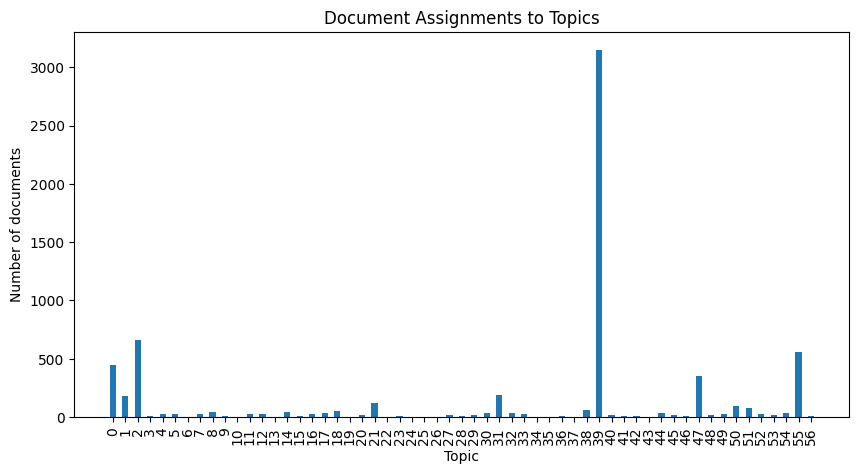

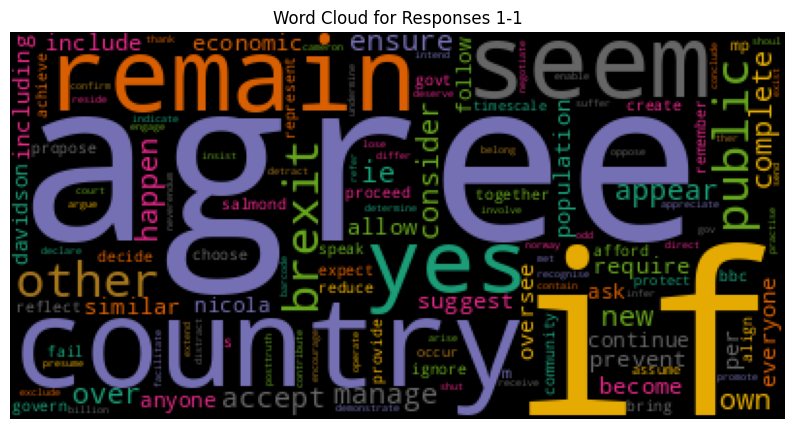

Error generating wordcloud: name 'io' is not defined


100%|██████████| 6806/6806 [00:15<00:00, 433.13it/s]


Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/779 [00:00<?, ?it/s]

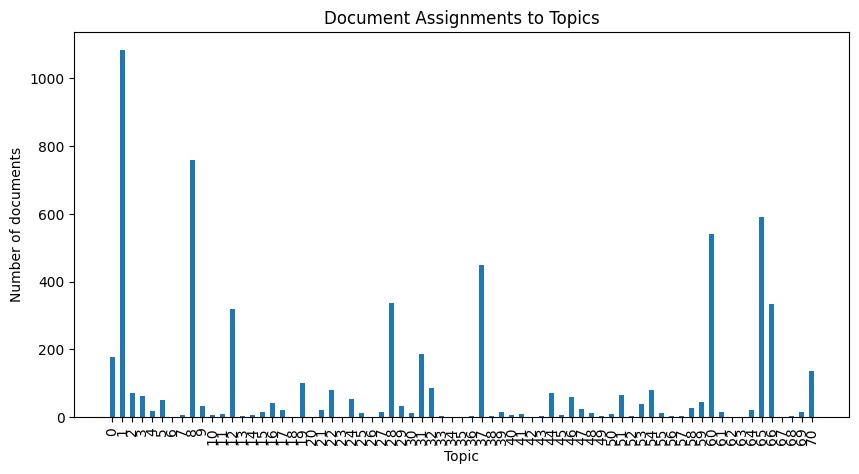

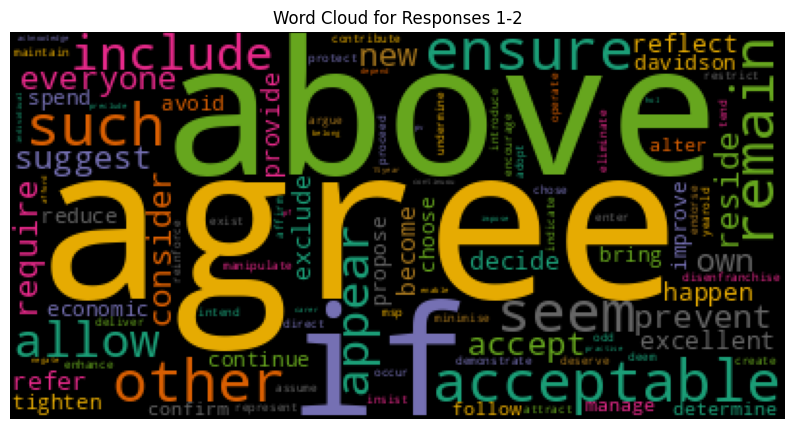

Error generating wordcloud: name 'io' is not defined


100%|██████████| 6806/6806 [00:10<00:00, 671.81it/s]


Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/709 [00:00<?, ?it/s]

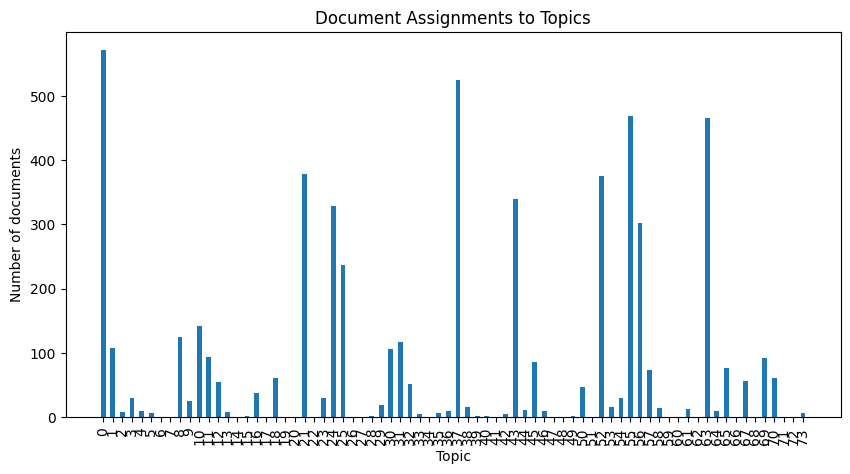

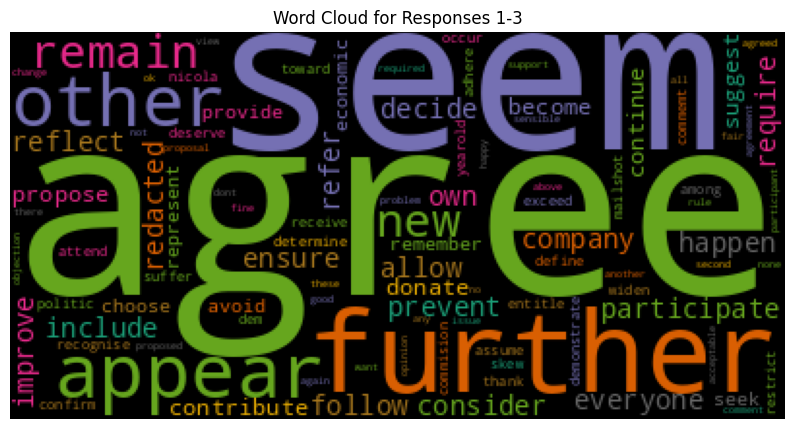

Error generating wordcloud: name 'io' is not defined


100%|██████████| 6806/6806 [00:04<00:00, 1576.13it/s]


Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/736 [00:00<?, ?it/s]

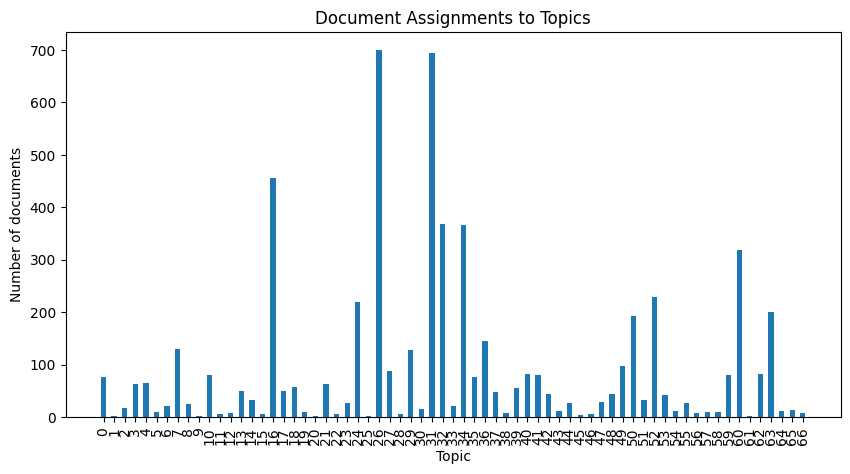

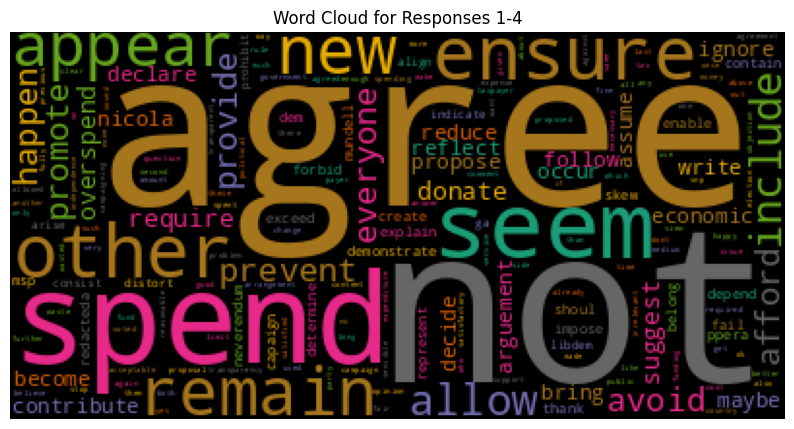

Error generating wordcloud: name 'io' is not defined


100%|██████████| 6806/6806 [00:05<00:00, 1185.86it/s]


Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/681 [00:00<?, ?it/s]

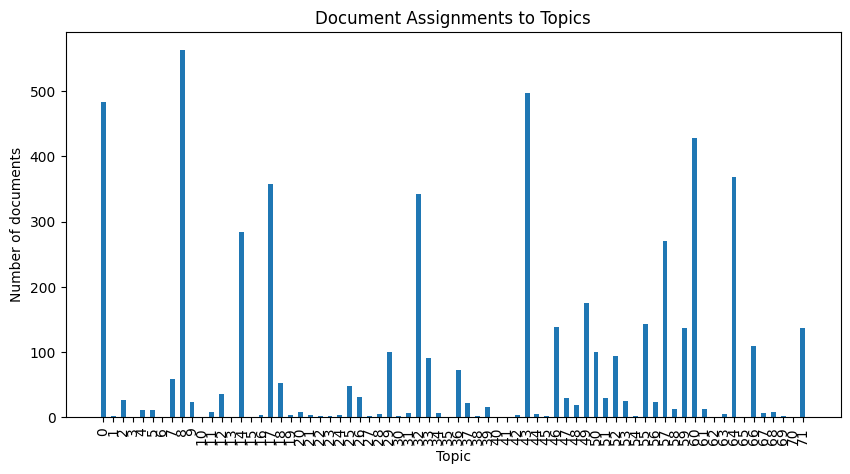

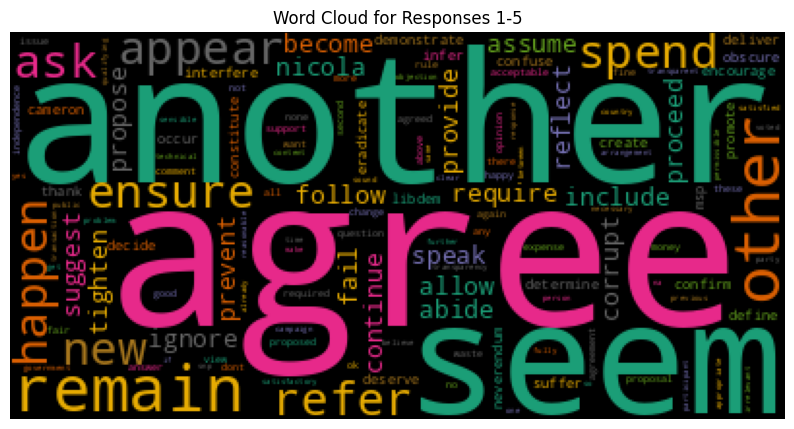

Error generating wordcloud: name 'io' is not defined


100%|██████████| 6806/6806 [00:03<00:00, 2074.37it/s]


Batches:   0%|          | 0/851 [00:00<?, ?it/s]

In [ ]:
question_ids = get_open_questions(1,conn,cursor)
for id in question_ids:
  responses = get_responses_to_question(id)
  filtered_responses = [resp for resp in get_responses_to_question(id) if resp[1] is not None]
  response_topics = process_responses(filtered_responses, id)
  insert_response_topic_data(response_topics, id)
  store_embeddings(responses, id)

### Consultation 2 Processing

In [ ]:
question_ids = get_open_questions(2,conn,cursor)
for id in question_ids:
  responses = get_responses_to_question(id)
  filtered_responses = [resp for resp in get_responses_to_question(id) if resp[1] is not None]
  response_topics = process_responses(filtered_responses, id)
  insert_response_topic_data(response_topics, id)
  store_embeddings(responses, id)

100%|██████████| 882/882 [00:00<00:00, 1472.66it/s]


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 882/882 [00:01<00:00, 771.13it/s]


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 882/882 [00:00<00:00, 1155.21it/s]


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 882/882 [00:01<00:00, 744.49it/s]


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 882/882 [00:01<00:00, 600.73it/s]


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 882/882 [00:00<00:00, 10991.63it/s]


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 882/882 [00:00<00:00, 16848.43it/s]


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 882/882 [00:01<00:00, 770.97it/s]


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 882/882 [00:00<00:00, 968.08it/s]


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 882/882 [00:03<00:00, 237.08it/s]


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 882/882 [00:02<00:00, 434.39it/s]


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 882/882 [00:00<00:00, 1017.90it/s]


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 882/882 [00:00<00:00, 1586.41it/s]


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 882/882 [00:00<00:00, 2233.96it/s]


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 882/882 [00:00<00:00, 1801.20it/s]


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 882/882 [00:00<00:00, 1556.76it/s]


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 882/882 [00:00<00:00, 14475.57it/s]


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 882/882 [00:00<00:00, 2723.19it/s]


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 882/882 [00:00<00:00, 1607.25it/s]


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 882/882 [00:00<00:00, 4013.01it/s]


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 882/882 [00:01<00:00, 777.88it/s]


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 882/882 [00:00<00:00, 1234.45it/s]


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 882/882 [00:01<00:00, 872.73it/s]


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

### Consultation 3 Processing

In [ ]:
question_ids = get_open_questions(3,conn,cursor)
for id in question_ids:
  responses = get_responses_to_question(id)
  filtered_responses = [resp for resp in get_responses_to_question(id) if resp[1] is not None]
  response_topics = process_responses(filtered_responses, id)
  insert_response_topic_data(response_topics, id)
  store_embeddings(responses, id)

100%|██████████| 422/422 [00:00<00:00, 492.40it/s]


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 422/422 [00:00<00:00, 1223.88it/s]


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 422/422 [00:00<00:00, 1522.50it/s]


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 422/422 [00:00<00:00, 2000.71it/s]


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 422/422 [00:00<00:00, 820.25it/s] 


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 422/422 [00:00<00:00, 2340.43it/s]


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 422/422 [00:00<00:00, 7452.87it/s]


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 422/422 [00:00<00:00, 1611.49it/s]


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 422/422 [00:00<00:00, 3341.73it/s]


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 422/422 [00:00<00:00, 3296.46it/s]


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 422/422 [00:00<00:00, 1398.62it/s]


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 422/422 [00:00<00:00, 824.89it/s] 


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 422/422 [00:00<00:00, 3484.24it/s]


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 422/422 [00:00<00:00, 18458.61it/s]


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 422/422 [00:00<00:00, 3047.51it/s]


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 422/422 [00:00<00:00, 21774.65it/s]


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 422/422 [00:00<00:00, 11772.11it/s]


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 422/422 [00:00<00:00, 23343.48it/s]


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 422/422 [00:00<00:00, 6001.19it/s]


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 422/422 [00:00<00:00, 8967.91it/s]


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 422/422 [00:00<00:00, 1612.12it/s]


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 422/422 [00:00<00:00, 4282.33it/s]


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 422/422 [00:00<00:00, 2999.32it/s]


Batches:   0%|          | 0/53 [00:00<?, ?it/s]